# 제품 이상여부 판별 프로젝트


## 1. 데이터 불러오기


### 필수 라이브러리


In [1]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm

### 데이터 읽어오기


In [2]:
ROOT_DIR = "data"
RANDOM_STATE = 110

# Load data
train_data = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))
train_data

,Wip Line_Dam,Process Desc._Dam,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Insp. Seq No._Dam,Insp Judge Code_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION X Unit Time_Dam,CURE END POSITION X Judge Value_Dam,...,Production Qty Collect Result_Fill2,Production Qty Unit Time_Fill2,Production Qty Judge Value_Fill2,Receip No Collect Result_Fill2,Receip No Unit Time_Fill2,Receip No Judge Value_Fill2,WorkMode Collect Result_Fill2,WorkMode Unit Time_Fill2,WorkMode Judge Value_Fill2,target
0,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,4F1XA938-1,1,OK,240.0,NaN,NaN,...,7,NaN,NaN,127,NaN,NaN,1,NaN,NaN,Normal
1,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,3KPM0016-2,1,OK,240.0,NaN,NaN,...,185,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
2,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1X9167-1,1,OK,1000.0,NaN,NaN,...,10,NaN,NaN,73,NaN,NaN,1,NaN,NaN,Normal
3,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3K1X0057-1,1,OK,1000.0,NaN,NaN,...,268,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
4,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3HPM0007-1,1,OK,240.0,NaN,NaN,...,121,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3J1XF434-2,1,OK,240.0,NaN,NaN,...,318,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
40502,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1XC796-1,1,OK,1000.0,NaN,NaN,...,14,NaN,NaN,197,NaN,NaN,1,NaN,NaN,Normal
40503,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,4C1XD438-1,1,OK,240.0,NaN,NaN,...,1,NaN,NaN,27,NaN,NaN,1,NaN,NaN,Normal
40504,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3I1XA258-1,1,OK,1000.0,NaN,NaN,...,117,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal


In [3]:
# Drop columns with more than half of the values missing
drop_cols = []
for column in train_data.columns:
    if (train_data[column].notnull().sum() // 2) < train_data[
        column
    ].isnull().sum():
        drop_cols.append(column)
train_data = train_data.drop(drop_cols, axis=1)

train_data

,Wip Line_Dam,Process Desc._Dam,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Insp. Seq No._Dam,Insp Judge Code_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,...,Head Clean Position Z Collect Result_Fill2,Head Purge Position X Collect Result_Fill2,Head Purge Position Y Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target
0,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,4F1XA938-1,1,OK,240.0,2.5,-90,...,50.0,91.8,270,50,114.612,19.9,7,127,1,Normal
1,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,3KPM0016-2,1,OK,240.0,2.5,-90,...,91.8,270.0,50,85,19.600,7.0,185,1,0,Normal
2,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1X9167-1,1,OK,1000.0,12.5,90,...,50.0,91.8,270,50,114.612,19.8,10,73,1,Normal
3,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3K1X0057-1,1,OK,1000.0,12.5,90,...,91.8,270.0,50,85,19.900,12.0,268,1,0,Normal
4,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3HPM0007-1,1,OK,240.0,2.5,-90,...,91.8,270.0,50,85,19.700,8.0,121,1,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3J1XF434-2,1,OK,240.0,2.5,-90,...,91.8,270.0,50,85,19.200,1.0,318,1,0,Normal
40502,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1XC796-1,1,OK,1000.0,12.5,90,...,50.0,91.8,270,50,114.612,20.5,14,197,1,Normal
40503,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,4C1XD438-1,1,OK,240.0,2.5,-90,...,50.0,91.8,270,50,85.000,19.7,1,27,1,Normal
40504,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3I1XA258-1,1,OK,1000.0,12.5,90,...,91.8,270.0,50,85,20.100,13.0,117,1,0,Normal


In [4]:
# 각 열의 NaN 값 개수 계산
nan_counts = train_data.isnull().sum()

# NaN 값이 있는 열들만 필터링
nan_columns = nan_counts[nan_counts > 0]

nan_columns

HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam      12766
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1    12766
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2    12766
dtype: int64

In [5]:
# 각 열의 NaN 값이 있는 행을 표시
nan_dam = train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].isnull()
nan_fill1 = train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].isnull()
nan_fill2 = train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].isnull()

# 세 열의 NaN 값이 모두 같은 행에서 발생했는지 확인
nan_same_rows = nan_dam & nan_fill1 & nan_fill2

# NaN 값이 동일한 행의 개수 확인
num_same_nan_rows = nan_same_rows.sum()

# 결과 출력
print(f"세 열에서 NaN 값이 동일한 행의 개수: {num_same_nan_rows}")
print(f"세 열에서 NaN 값이 동일한 행:\n{train_data[nan_same_rows]}")

세 열에서 NaN 값이 동일한 행의 개수: 12766
세 열에서 NaN 값이 동일한 행:
      Wip Line_Dam Process Desc._Dam     Equipment_Dam Model.Suffix_Dam  \
0          IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334505   
12         IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334501   
13         IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334501   
18         IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   
24         IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334507   
...            ...               ...               ...              ...   
40485      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   
40491      IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334501   
40492      IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334501   
40500      IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334501   
40502      IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334501   

       Workorder_Dam  Insp. Seq No._Dam Insp Judg

In [6]:
# 열 목록을 정의
required_columns = [
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2',
    'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave',
    'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave'
]

# 존재하는 열들만 필터링
existing_columns = [col for col in required_columns if col in train_data.columns]

# 존재하는 열들 출력
print("존재하는 열들:", existing_columns)

존재하는 열들: []


In [7]:
# Model.Suffix의 값이 공정에 따라 같은지 다른지 비교할 열 리스트
suffix_columns = [
    'Model.Suffix_Dam',
    'Model.Suffix_Fill1',
    'Model.Suffix_Fill2',
    'Model.Suffix_AutoClave'
]

# 각 행에 대해 모든 비교 열의 값이 동일한지 확인
all_equal = train_data[suffix_columns].nunique(axis=1) == 1

# 동일한 값을 가진 행만 필터링하여 네 개의 열만 선택
equal_rows = train_data.loc[all_equal, suffix_columns]

# 동일한 값을 가진 행의 개수와 결과 출력
print(f"동일한 값을 가진 행의 개수: {len(equal_rows)}")
print(equal_rows)

동일한 값을 가진 행의 개수: 40506
      Model.Suffix_Dam Model.Suffix_Fill1 Model.Suffix_Fill2  \
0          AJX75334505        AJX75334505        AJX75334505   
1          AJX75334505        AJX75334505        AJX75334505   
2          AJX75334501        AJX75334501        AJX75334501   
3          AJX75334501        AJX75334501        AJX75334501   
4          AJX75334501        AJX75334501        AJX75334501   
...                ...                ...                ...   
40501      AJX75334501        AJX75334501        AJX75334501   
40502      AJX75334501        AJX75334501        AJX75334501   
40503      AJX75334501        AJX75334501        AJX75334501   
40504      AJX75334501        AJX75334501        AJX75334501   
40505      AJX75334501        AJX75334501        AJX75334501   

      Model.Suffix_AutoClave  
0                AJX75334505  
1                AJX75334505  
2                AJX75334501  
3                AJX75334501  
4                AJX75334501  
...                   

In [8]:
# Workorder의 값이 공정에 따라 같은지 다른지 비교할 열 리스트
suffix_columns = [
    'Workorder_Dam',
    'Workorder_Fill1',
    'Workorder_Fill2',
    'Workorder_AutoClave'
]

# 각 행에 대해 모든 비교 열의 값이 동일한지 확인
all_equal = train_data[suffix_columns].nunique(axis=1) == 1

# 동일한 값을 가진 행만 필터링하여 네 개의 열만 선택
equal_rows = train_data.loc[all_equal, suffix_columns]

# 동일한 값을 가진 행의 개수와 결과 출력
print(f"동일한 값을 가진 행의 개수: {len(equal_rows)}")
print(equal_rows)

동일한 값을 가진 행의 개수: 40506
      Workorder_Dam Workorder_Fill1 Workorder_Fill2 Workorder_AutoClave
0        4F1XA938-1      4F1XA938-1      4F1XA938-1          4F1XA938-1
1        3KPM0016-2      3KPM0016-2      3KPM0016-2          3KPM0016-2
2        4E1X9167-1      4E1X9167-1      4E1X9167-1          4E1X9167-1
3        3K1X0057-1      3K1X0057-1      3K1X0057-1          3K1X0057-1
4        3HPM0007-1      3HPM0007-1      3HPM0007-1          3HPM0007-1
...             ...             ...             ...                 ...
40501    3J1XF434-2      3J1XF434-2      3J1XF434-2          3J1XF434-2
40502    4E1XC796-1      4E1XC796-1      4E1XC796-1          4E1XC796-1
40503    4C1XD438-1      4C1XD438-1      4C1XD438-1          4C1XD438-1
40504    3I1XA258-1      3I1XA258-1      3I1XA258-1          3I1XA258-1
40505    3G1XA501-1      3G1XA501-1      3G1XA501-1          3G1XA501-1

[40506 rows x 4 columns]


In [9]:
# 삭제할 열 리스트
columns_to_drop = [
        'Model.Suffix_Fill1', 'Model.Suffix_Fill2', 'Model.Suffix_AutoClave', 
        'Workorder_Fill1', 'Workorder_Fill2', 'Workorder_AutoClave'
]

# 열 삭제
train_data = train_data.drop(columns=columns_to_drop)

# 열 이름 변경
train_data = train_data.rename(columns={
    'Model.Suffix_Dam': 'Model.Suffix',
    'Workorder_Dam': 'Workorder'
})

train_data

,Wip Line_Dam,Process Desc._Dam,Equipment_Dam,Model.Suffix,Workorder,Insp. Seq No._Dam,Insp Judge Code_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,...,Head Clean Position Z Collect Result_Fill2,Head Purge Position X Collect Result_Fill2,Head Purge Position Y Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target
0,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,4F1XA938-1,1,OK,240.0,2.5,-90,...,50.0,91.8,270,50,114.612,19.9,7,127,1,Normal
1,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,3KPM0016-2,1,OK,240.0,2.5,-90,...,91.8,270.0,50,85,19.600,7.0,185,1,0,Normal
2,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1X9167-1,1,OK,1000.0,12.5,90,...,50.0,91.8,270,50,114.612,19.8,10,73,1,Normal
3,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3K1X0057-1,1,OK,1000.0,12.5,90,...,91.8,270.0,50,85,19.900,12.0,268,1,0,Normal
4,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3HPM0007-1,1,OK,240.0,2.5,-90,...,91.8,270.0,50,85,19.700,8.0,121,1,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3J1XF434-2,1,OK,240.0,2.5,-90,...,91.8,270.0,50,85,19.200,1.0,318,1,0,Normal
40502,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1XC796-1,1,OK,1000.0,12.5,90,...,50.0,91.8,270,50,114.612,20.5,14,197,1,Normal
40503,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,4C1XD438-1,1,OK,240.0,2.5,-90,...,50.0,91.8,270,50,85.000,19.7,1,27,1,Normal
40504,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3I1XA258-1,1,OK,1000.0,12.5,90,...,91.8,270.0,50,85,20.100,13.0,117,1,0,Normal


In [10]:
# 모든 행이 동일한 값을 가지는 열을 찾고, 그 값을 함께 저장
constant_columns = {col: train_data[col].iloc[0] for col in train_data.columns if train_data[col].nunique() == 1}

# 데이터 프레임에서 해당 열 삭제
train_data = train_data.drop(columns=constant_columns.keys())

# 삭제된 열의 개수 출력
print(f"삭제된 열의 개수: {len(constant_columns)}")

# 삭제된 열과 그 값을 한 줄에 하나씩 출력
print("삭제된 열과 값:")
for col, value in constant_columns.items():
    print(f"{col}: {value}")

train_data

삭제된 열의 개수: 35
삭제된 열과 값:
Wip Line_Dam: IVI-OB6
Process Desc._Dam: Dam Dispenser
Insp. Seq No._Dam: 1
Insp Judge Code_Dam: OK
CURE STANDBY POSITION X Collect Result_Dam: 1150
CURE STANDBY POSITION Z Collect Result_Dam: 33.5
CURE STANDBY POSITION Θ Collect Result_Dam: 0
CURE START POSITION Z Collect Result_Dam: 33.5
Wip Line_AutoClave: IVI-OB6
Process Desc._AutoClave: Auto Clave Out
Equipment_AutoClave: Auto Clave Out
Insp. Seq No._AutoClave: 1
Insp Judge Code_AutoClave: OK
1st Pressure Judge Value_AutoClave: OK
2nd Pressure Judge Value_AutoClave: OK
3rd Pressure Judge Value_AutoClave: OK
Wip Line_Fill1: IVI-OB6
Process Desc._Fill1: Fill1 Dispenser
Insp. Seq No._Fill1: 1
Insp Judge Code_Fill1: OK
Wip Line_Fill2: IVI-OB6
Process Desc._Fill2: Fill2 Dispenser
Insp. Seq No._Fill2: 1
Insp Judge Code_Fill2: OK
CURE END POSITION Θ Collect Result_Fill2: -90
CURE STANDBY POSITION X Collect Result_Fill2: 1020
CURE STANDBY POSITION Θ Collect Result_Fill2: 0
CURE START POSITION Θ Collect Result_Fill2

,Equipment_Dam,Model.Suffix,Workorder,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,...,Head Clean Position Z Collect Result_Fill2,Head Purge Position X Collect Result_Fill2,Head Purge Position Y Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target
0,Dam dispenser #1,AJX75334505,4F1XA938-1,240.0,2.5,-90,100,1030,-90,16,...,50.0,91.8,270,50,114.612,19.9,7,127,1,Normal
1,Dam dispenser #1,AJX75334505,3KPM0016-2,240.0,2.5,-90,70,1030,-90,10,...,91.8,270.0,50,85,19.600,7.0,185,1,0,Normal
2,Dam dispenser #2,AJX75334501,4E1X9167-1,1000.0,12.5,90,85,280,90,16,...,50.0,91.8,270,50,114.612,19.8,10,73,1,Normal
3,Dam dispenser #2,AJX75334501,3K1X0057-1,1000.0,12.5,90,70,280,90,10,...,91.8,270.0,50,85,19.900,12.0,268,1,0,Normal
4,Dam dispenser #1,AJX75334501,3HPM0007-1,240.0,2.5,-90,70,1030,-90,10,...,91.8,270.0,50,85,19.700,8.0,121,1,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,Dam dispenser #1,AJX75334501,3J1XF434-2,240.0,2.5,-90,70,1030,-90,10,...,91.8,270.0,50,85,19.200,1.0,318,1,0,Normal
40502,Dam dispenser #2,AJX75334501,4E1XC796-1,1000.0,12.5,90,100,280,90,16,...,50.0,91.8,270,50,114.612,20.5,14,197,1,Normal
40503,Dam dispenser #1,AJX75334501,4C1XD438-1,240.0,2.5,-90,100,1030,-90,16,...,50.0,91.8,270,50,85.000,19.7,1,27,1,Normal
40504,Dam dispenser #2,AJX75334501,3I1XA258-1,1000.0,12.5,90,70,280,90,10,...,91.8,270.0,50,85,20.100,13.0,117,1,0,Normal


In [11]:
# 열 이름 정의
target_column = 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'

# 열의 값들 확인
if target_column not in train_data.columns:
    raise ValueError(f"열 '{target_column}'이(가) 데이터프레임에 없습니다.")

# 고유한 값 추출
unique_values = train_data[target_column].unique()

# 고유한 값들을 포함한 DataFrame 생성
unique_values_df = pd.DataFrame(unique_values, columns=[target_column])

# 결측치와 문자열 포함 모든 고유 값 출력
print(f"'{target_column}' 열의 고유한 값들:")
print(unique_values_df)

# 추가로 결측치와 특정 값('OK')의 존재 여부 확인
nan_count = train_data[target_column].isna().sum()
ok_count = (train_data[target_column] == 'OK').sum()

print(f"\n결측치(NaN) 개수: {nan_count}")
print(f"'OK' 값 개수: {ok_count}")

'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam' 열의 고유한 값들:
  HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam
0                                                NaN      
1                                              550.3      
2                                                 OK      
3                                              162.4      
4                                                549      
5                                              549.5      
6                                                550      
7                                              548.5      

결측치(NaN) 개수: 12766
'OK' 값 개수: 11293


In [12]:
# 열 이름 정의
column_name = 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'

# 열이 데이터프레임에 존재하는지 확인
if column_name not in train_data.columns:
    raise ValueError(f"열 '{column_name}'이(가) 데이터프레임에 없습니다.")

# 해당 열의 모든 값이 숫자인지 확인
has_numeric = train_data[column_name].apply(pd.to_numeric, errors='coerce').notna().any()

# 결과 출력
if has_numeric:
    print(f"열 '{column_name}'에는 숫자가 포함되어 있습니다.")
else:
    print(f"열 '{column_name}'에는 숫자가 포함되어 있지 않습니다.")


열 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'에는 숫자가 포함되어 있습니다.


In [13]:
# 열 이름 정의
column_name = 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'

# 데이터프레임에서 숫자와 숫자가 아닌 값으로 구분하여 두 개의 데이터프레임 생성
train_noshift = train_data[pd.to_numeric(train_data[column_name], errors='coerce').notna()]
train_shift = train_data[pd.to_numeric(train_data[column_name], errors='coerce').isna() | (train_data[column_name] == 'OK')]

# 결과 출력
print("숫자인 경우의 데이터프레임 (train_noshift):")
print(train_noshift)

print("\n숫자가 아닌 경우의 데이터프레임 (train_shift):")
print(train_shift)

# 결과파일 저장
# train_noshift.to_csv('train_noshift.csv', index=False)
# train_shift.to_csv('train_shift.csv', index=False)

숫자인 경우의 데이터프레임 (train_noshift):
          Equipment_Dam Model.Suffix   Workorder  \
1      Dam dispenser #1  AJX75334505  3KPM0016-2   
3      Dam dispenser #2  AJX75334501  3K1X0057-1   
4      Dam dispenser #1  AJX75334501  3HPM0007-1   
5      Dam dispenser #1  AJX75334501  3G1X8297-2   
8      Dam dispenser #1  AJX75334501  3H1X9883-1   
...                 ...          ...         ...   
40497  Dam dispenser #1  AJX75334501  3H1XC952-1   
40498  Dam dispenser #1  AJX75334501  3H1X7981-1   
40501  Dam dispenser #1  AJX75334501  3J1XF434-2   
40504  Dam dispenser #2  AJX75334501  3I1XA258-1   
40505  Dam dispenser #1  AJX75334501  3G1XA501-1   

       CURE END POSITION X Collect Result_Dam  \
1                                       240.0   
3                                      1000.0   
4                                       240.0   
5                                       240.0   
8                                       240.0   
...                                       ...   


In [14]:
# 열 이름 정의
column_fill1 = 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'

# train_noshift1 및 train_shift1 데이터프레임 생성
train_noshift1 = train_data[pd.to_numeric(train_data[column_fill1], errors='coerce').notna()]
train_shift1 = train_data[pd.to_numeric(train_data[column_fill1], errors='coerce').isna() | (train_data[column_fill1] == 'OK')]

# train_shift와 train_shift1 데이터프레임이 같은지 확인
def are_dataframes_equal(df1, df2):
    return df1.equals(df2)

# train_shift와 train_shift1 비교
dataframes_equal = are_dataframes_equal(train_shift, train_shift1)

# 결과 출력
print("숫자인 경우의 데이터프레임 (train_noshift1):")
print(train_noshift1)

print("\n숫자가 아닌 경우의 데이터프레임 (train_shift1):")
print(train_shift1)

print("\ntrain_shift와 train_shift1이 같은가요?:", dataframes_equal)

숫자인 경우의 데이터프레임 (train_noshift1):
          Equipment_Dam Model.Suffix   Workorder  \
1      Dam dispenser #1  AJX75334505  3KPM0016-2   
3      Dam dispenser #2  AJX75334501  3K1X0057-1   
4      Dam dispenser #1  AJX75334501  3HPM0007-1   
5      Dam dispenser #1  AJX75334501  3G1X8297-2   
8      Dam dispenser #1  AJX75334501  3H1X9883-1   
...                 ...          ...         ...   
40497  Dam dispenser #1  AJX75334501  3H1XC952-1   
40498  Dam dispenser #1  AJX75334501  3H1X7981-1   
40501  Dam dispenser #1  AJX75334501  3J1XF434-2   
40504  Dam dispenser #2  AJX75334501  3I1XA258-1   
40505  Dam dispenser #1  AJX75334501  3G1XA501-1   

       CURE END POSITION X Collect Result_Dam  \
1                                       240.0   
3                                      1000.0   
4                                       240.0   
5                                       240.0   
8                                       240.0   
...                                       ...   

In [15]:
# 선택할 열 범위
start_col = 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'
end_col = 'WorkMode Collect Result_Dam'

# 열 인덱스 찾기
start_index = train_shift.columns.get_loc(start_col)
end_index = train_shift.columns.get_loc(end_col)

# 선택할 열 범위 설정
cols_to_shift = train_shift.iloc[:, start_index:end_index + 1].copy()

# 선택한 열에 대해 shift 적용 (값만 이동)
shifted_values = cols_to_shift.shift(-1, axis=1)

# 원래 데이터프레임에서 선택한 열의 위치에 값만 덮어쓰기
for i, col in enumerate(cols_to_shift.columns):
    train_shift[col] = shifted_values.iloc[:, i]

/var/folders/zf/6h5l4dc57cj2qkp7wv1dz7zr0000gn/T/ipykernel_1412/2970819967.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_shift[col] = shifted_values.iloc[:, i]


In [16]:
# 선택할 열 범위
start_col = 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'
end_col = 'WorkMode Collect Result_Fill1'

# 열 인덱스 찾기
start_index = train_shift.columns.get_loc(start_col)
end_index = train_shift.columns.get_loc(end_col)

# 선택할 열 범위 설정
cols_to_shift = train_shift.iloc[:, start_index:end_index + 1].copy()

# 선택한 열에 대해 shift 적용 (값만 이동)
shifted_values = cols_to_shift.shift(-1, axis=1)

# 원래 데이터프레임에서 선택한 열의 위치에 값만 덮어쓰기
for i, col in enumerate(cols_to_shift.columns):
    train_shift[col] = shifted_values.iloc[:, i]

/var/folders/zf/6h5l4dc57cj2qkp7wv1dz7zr0000gn/T/ipykernel_1412/3756343480.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_shift[col] = shifted_values.iloc[:, i]


In [17]:
# 선택할 열 범위
start_col = 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'
end_col = 'WorkMode Collect Result_Fill2'

# 열 인덱스 찾기
start_index = train_shift.columns.get_loc(start_col)
end_index = train_shift.columns.get_loc(end_col)

# 선택할 열 범위 설정
cols_to_shift = train_shift.iloc[:, start_index:end_index + 1].copy()

# 선택한 열에 대해 shift 적용 (값만 이동)
shifted_values = cols_to_shift.shift(-1, axis=1)

# 원래 데이터프레임에서 선택한 열의 위치에 값만 덮어쓰기
for i, col in enumerate(cols_to_shift.columns):
    train_shift[col] = shifted_values.iloc[:, i]

# 결과를 파일로 저장
# train_shift.to_csv('train_shift_corrected.csv', index=False)

/var/folders/zf/6h5l4dc57cj2qkp7wv1dz7zr0000gn/T/ipykernel_1412/2277645347.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_shift[col] = shifted_values.iloc[:, i]


In [18]:
# 열 순서 출력
print("열 순서:")
for i, col in enumerate(train_shift.columns, start=1):
    print(f"{i}: {col}")

열 순서:
1: Equipment_Dam
2: Model.Suffix
3: Workorder
4: CURE END POSITION X Collect Result_Dam
5: CURE END POSITION Z Collect Result_Dam
6: CURE END POSITION Θ Collect Result_Dam
7: CURE SPEED Collect Result_Dam
8: CURE START POSITION X Collect Result_Dam
9: CURE START POSITION Θ Collect Result_Dam
10: DISCHARGED SPEED OF RESIN Collect Result_Dam
11: DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam
12: DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam
13: DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam
14: Dispense Volume(Stage1) Collect Result_Dam
15: Dispense Volume(Stage2) Collect Result_Dam
16: Dispense Volume(Stage3) Collect Result_Dam
17: HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam
18: HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam
19: HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam
20: HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam
21: HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam
22: HEAD NORMAL COORDINATE Y AXIS(Stag

In [19]:
# 열 순서 출력
print("열 순서:")
for i, col in enumerate(train_noshift.columns, start=1):
    print(f"{i}: {col}")

열 순서:
1: Equipment_Dam
2: Model.Suffix
3: Workorder
4: CURE END POSITION X Collect Result_Dam
5: CURE END POSITION Z Collect Result_Dam
6: CURE END POSITION Θ Collect Result_Dam
7: CURE SPEED Collect Result_Dam
8: CURE START POSITION X Collect Result_Dam
9: CURE START POSITION Θ Collect Result_Dam
10: DISCHARGED SPEED OF RESIN Collect Result_Dam
11: DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam
12: DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam
13: DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam
14: Dispense Volume(Stage1) Collect Result_Dam
15: Dispense Volume(Stage2) Collect Result_Dam
16: Dispense Volume(Stage3) Collect Result_Dam
17: HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam
18: HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam
19: HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam
20: HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam
21: HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam
22: HEAD NORMAL COORDINATE Y AXIS(Stag

In [20]:
# 두 데이터프레임 합치기
combined_df = pd.concat([train_shift, train_noshift], axis=0)
combined_df=combined_df.sort_index()

# 제거할 열 리스트
columns_to_drop = ['WorkMode Collect Result_Dam', 'WorkMode Collect Result_Fill1', 'WorkMode Collect Result_Fill2']

# 지정한 열 제거
combined_df = combined_df.drop(columns=columns_to_drop)

# 결과를 CSV 파일로 저장
combined_df.to_csv('train_shift_final.csv', index=False)

combined_df

,Equipment_Dam,Model.Suffix,Workorder,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,...,Head Clean Position Y Collect Result_Fill2,Head Clean Position Z Collect Result_Fill2,Head Purge Position X Collect Result_Fill2,Head Purge Position Y Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,target
0,Dam dispenser #1,AJX75334505,4F1XA938-1,240.0,2.5,-90,100,1030,-90,16,...,50.0,91.8,270.0,50,114.612,19.9,7.0,127,1,Normal
1,Dam dispenser #1,AJX75334505,3KPM0016-2,240.0,2.5,-90,70,1030,-90,10,...,50.0,91.8,270.0,50,85.000,19.6,7.0,185,1,Normal
2,Dam dispenser #2,AJX75334501,4E1X9167-1,1000.0,12.5,90,85,280,90,16,...,50.0,91.8,270.0,50,114.612,19.8,10.0,73,1,Normal
3,Dam dispenser #2,AJX75334501,3K1X0057-1,1000.0,12.5,90,70,280,90,10,...,50.0,91.8,270.0,50,85.000,19.9,12.0,268,1,Normal
4,Dam dispenser #1,AJX75334501,3HPM0007-1,240.0,2.5,-90,70,1030,-90,10,...,50.0,91.8,270.0,50,85.000,19.7,8.0,121,1,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,Dam dispenser #1,AJX75334501,3J1XF434-2,240.0,2.5,-90,70,1030,-90,10,...,50.0,91.8,270.0,50,85.000,19.2,1.0,318,1,Normal
40502,Dam dispenser #2,AJX75334501,4E1XC796-1,1000.0,12.5,90,100,280,90,16,...,50.0,91.8,270.0,50,114.612,20.5,14.0,197,1,Normal
40503,Dam dispenser #1,AJX75334501,4C1XD438-1,240.0,2.5,-90,100,1030,-90,16,...,50.0,91.8,270.0,50,85.000,19.7,1.0,27,1,Normal
40504,Dam dispenser #2,AJX75334501,3I1XA258-1,1000.0,12.5,90,70,280,90,10,...,50.0,91.8,270.0,50,85.000,20.1,13.0,117,1,Normal


In [21]:
# 모든 행이 동일한 값을 가지는 열을 찾고, 그 값을 함께 저장
constant_columns = {col: combined_df[col].iloc[0] for col in combined_df.columns if combined_df[col].nunique() == 1}

# 데이터 프레임에서 해당 열 삭제
combined_df = combined_df.drop(columns=constant_columns.keys())

# 삭제된 열의 개수 출력
print(f"삭제된 열의 개수: {len(constant_columns)}")

# 삭제된 열과 그 값을 한 줄에 하나씩 출력
print("삭제된 열과 값:")
for col, value in constant_columns.items():
    print(f"{col}: {value}")

combined_df

삭제된 열의 개수: 24
삭제된 열과 값:
HEAD Standby Position X Collect Result_Dam: 257.0
HEAD Standby Position Y Collect Result_Dam: 66
HEAD Standby Position Z Collect Result_Dam: 0.0
Head Clean Position X Collect Result_Dam: 127.5
Head Clean Position Y Collect Result_Dam: 66.0
Head Purge Position X Collect Result_Dam: 257.0
Head Purge Position Y Collect Result_Dam: 66.0
Head Zero Position X Collect Result_Dam: 505.0
HEAD Standby Position X Collect Result_Fill1: 289.0
HEAD Standby Position Y Collect Result_Fill1: 50
HEAD Standby Position Z Collect Result_Fill1: 0.0
Head Clean Position X Collect Result_Fill1: 123.4
Head Clean Position Y Collect Result_Fill1: 50.0
Head Clean Position Z Collect Result_Fill1: 92.2
Head Purge Position X Collect Result_Fill1: 289.0
Head Purge Position Y Collect Result_Fill1: 50
HEAD Standby Position X Collect Result_Fill2: 270.0
HEAD Standby Position Y Collect Result_Fill2: 50
HEAD Standby Position Z Collect Result_Fill2: -10
Head Clean Position X Collect Result_Fill2: 119

,Equipment_Dam,Model.Suffix,Workorder,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,...,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,target
0,Dam dispenser #1,AJX75334505,4F1XA938-1,240.0,2.5,-90,100,1030,-90,16,...,428.0,243.7,243.7,243.7,114.612,19.9,7.0,127,1,Normal
1,Dam dispenser #1,AJX75334505,3KPM0016-2,240.0,2.5,-90,70,1030,-90,10,...,428.0,243.7,243.7,243.7,85.000,19.6,7.0,185,1,Normal
2,Dam dispenser #2,AJX75334501,4E1X9167-1,1000.0,12.5,90,85,280,90,16,...,1324.2,243.5,243.5,243.5,114.612,19.8,10.0,73,1,Normal
3,Dam dispenser #2,AJX75334501,3K1X0057-1,1000.0,12.5,90,70,280,90,10,...,1324.2,243.5,243.5,243.5,85.000,19.9,12.0,268,1,Normal
4,Dam dispenser #1,AJX75334501,3HPM0007-1,240.0,2.5,-90,70,1030,-90,10,...,428.0,243.7,243.7,243.7,85.000,19.7,8.0,121,1,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,Dam dispenser #1,AJX75334501,3J1XF434-2,240.0,2.5,-90,70,1030,-90,10,...,428.0,243.7,243.7,243.7,85.000,19.2,1.0,318,1,Normal
40502,Dam dispenser #2,AJX75334501,4E1XC796-1,1000.0,12.5,90,100,280,90,16,...,1324.2,243.5,243.5,243.5,114.612,20.5,14.0,197,1,Normal
40503,Dam dispenser #1,AJX75334501,4C1XD438-1,240.0,2.5,-90,100,1030,-90,16,...,428.0,243.7,243.7,243.7,85.000,19.7,1.0,27,1,Normal
40504,Dam dispenser #2,AJX75334501,3I1XA258-1,1000.0,12.5,90,70,280,90,10,...,1324.2,243.5,243.5,243.5,85.000,20.1,13.0,117,1,Normal


In [22]:
# 각 열의 NaN 값 개수 계산
nan_counts = combined_df.isnull().sum()

# NaN 값이 있는 열들만 필터링
nan_columns = nan_counts[nan_counts > 0]

nan_columns

Series([], dtype: int64)

In [23]:
# 문자열 타입인 열들의 이름과 데이터 타입 출력
string_columns = combined_df.select_dtypes(include='object')
string_columns.dtypes

Equipment_Dam                                                 object
Model.Suffix                                                  object
Workorder                                                     object
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam      object
Chamber Temp. Judge Value_AutoClave                           object
Equipment_Fill1                                               object
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1    object
Equipment_Fill2                                               object
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2    object
target                                                        object
dtype: object

In [24]:
# 변환할 열들의 리스트
columns_to_convert = [
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2']

# 각 열을 float로 변환
for col in columns_to_convert:
    combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')

combined_df[columns_to_convert].dtypes

HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam      float64
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1    float64
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2    float64
dtype: object

In [25]:
from itertools import combinations
from collections import defaultdict

# 동일한 값을 가지는 열 쌍을 저장할 리스트
equal_columns = []

# 열 이름들의 모든 쌍을 생성하여 비교
for col1, col2 in combinations(combined_df.columns, 2):
    if combined_df[col1].equals(combined_df[col2]):
        equal_columns.append((col1, col2))

# 열 쌍을 그룹화하여 저장할 딕셔너리
grouped_columns = defaultdict(set)

# 열 쌍을 그룹화
for col1, col2 in equal_columns:
    grouped_columns[col1].add(col2)
    grouped_columns[col2].add(col1)

# 방문한 열을 추적할 집합
visited = set()

# 그룹화된 열 쌍 출력
print("같은 값을 가지는 열 그룹:")
for col, group in grouped_columns.items():
    if col not in visited:
        # 현재 열과 연결된 모든 열을 그룹으로 묶기
        group.add(col)
        visited.update(group)
        print(f"그룹: {', '.join(group)}")

같은 값을 가지는 열 그룹:
그룹: CURE START POSITION Θ Collect Result_Dam, CURE END POSITION Θ Collect Result_Dam
그룹: HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam, HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam, HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam
그룹: Stage1 Line2 Distance Speed Collect Result_Dam, Stage1 Circle1 Distance Speed Collect Result_Dam, Stage1 Circle4 Distance Speed Collect Result_Dam, Stage1 Circle3 Distance Speed Collect Result_Dam, Stage1 Line4 Distance Speed Collect Result_Dam, Stage1 Circle2 Distance Speed Collect Result_Dam
그룹: Stage2 Circle3 Distance Speed Collect Result_Dam, Stage2 Circle1 Distance Speed Collect Result_Dam, Stage2 Circle2 Distance Speed Collect Result_Dam, Stage2 Circle4 Distance Speed Collect Result_Dam
그룹: Stage2 Line2 Distance Speed Collect Result_Dam, Stage2 Line4 Distance Speed Collect Result_Dam
그룹: Stage3 Circle2 Distance Speed Collect Result_Dam, Stage3 Line4 Distance Speed Collect Result_Dam, Stage3 Line2 Distan

In [26]:
# 확인하기

# 비교할 열 리스트
columns_to_compare = [
    'Stage3 Circle1 Distance Speed Collect Result_Dam',
    'Stage3 Circle2 Distance Speed Collect Result_Dam',
    'Stage3 Circle3 Distance Speed Collect Result_Dam',
    'Stage3 Circle4 Distance Speed Collect Result_Dam',
    'Stage3 Line2 Distance Speed Collect Result_Dam',
    'Stage3 Line4 Distance Speed Collect Result_Dam' 

]

# 선택한 열 데이터만 포함하는 데이터프레임 생성
df_comparison = combined_df[columns_to_compare]

# 모든 행에 대해 열 값이 동일한지 확인
all_rows_identical = df_comparison.nunique(axis=1).eq(1).all()

if all_rows_identical:
    print("모든 행에서 열들의 값이 동일합니다.")
else:
    print("일부 행에서 열들의 값이 동일하지 않습니다.")

모든 행에서 열들의 값이 동일합니다.


In [27]:
# 삭제할 열 목록
columns_to_drop = [
    'CURE END POSITION Θ Collect Result_Dam',

    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam',

    'Stage1 Circle2 Distance Speed Collect Result_Dam',
    'Stage1 Circle3 Distance Speed Collect Result_Dam',
    'Stage1 Circle4 Distance Speed Collect Result_Dam',
    'Stage1 Line2 Distance Speed Collect Result_Dam',
    'Stage1 Line4 Distance Speed Collect Result_Dam',

    'Stage2 Circle2 Distance Speed Collect Result_Dam',
    'Stage2 Circle3 Distance Speed Collect Result_Dam',
    'Stage2 Circle4 Distance Speed Collect Result_Dam',

    'Stage2 Line4 Distance Speed Collect Result_Dam',

    'Stage3 Circle2 Distance Speed Collect Result_Dam',
    'Stage3 Circle3 Distance Speed Collect Result_Dam',
    'Stage3 Circle4 Distance Speed Collect Result_Dam',
    'Stage3 Line2 Distance Speed Collect Result_Dam',
    'Stage3 Line4 Distance Speed Collect Result_Dam',

    'CURE STANDBY POSITION Z Collect Result_Fill2',

    'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2',

    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2',
    
    'Model.Suffix', 
    'Chamber Temp. Judge Value_AutoClave',   
    'Workorder'
]
 

# 열 삭제
combined_df = combined_df.drop(columns=columns_to_drop)

# 결과 확인
combined_df

,Equipment_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,...,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,target
0,Dam dispenser #1,240.0,2.5,100,1030,-90,16,14.9,8.4,14.7,...,156.0,428.0,427.9,243.7,114.612,19.9,7.0,127,1,Normal
1,Dam dispenser #1,240.0,2.5,70,1030,-90,10,21.3,4.9,21.3,...,156.0,428.0,427.9,243.7,85.000,19.6,7.0,185,1,Normal
2,Dam dispenser #2,1000.0,12.5,85,280,90,16,14.7,8.5,14.7,...,694.0,1324.2,1324.2,243.5,114.612,19.8,10.0,73,1,Normal
3,Dam dispenser #2,1000.0,12.5,70,280,90,10,21.3,8.4,21.3,...,694.0,1324.2,1324.2,243.5,85.000,19.9,12.0,268,1,Normal
4,Dam dispenser #1,240.0,2.5,70,1030,-90,10,9.7,4.9,9.6,...,156.0,428.0,427.9,243.7,85.000,19.7,8.0,121,1,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,Dam dispenser #1,240.0,2.5,70,1030,-90,10,17.0,5.0,17.0,...,156.0,428.0,427.9,243.7,85.000,19.2,1.0,318,1,Normal
40502,Dam dispenser #2,1000.0,12.5,100,280,90,16,14.9,8.5,14.7,...,692.8,1324.2,1324.2,243.5,114.612,20.5,14.0,197,1,Normal
40503,Dam dispenser #1,240.0,2.5,100,1030,-90,16,14.2,8.2,14.3,...,156.0,428.0,427.9,243.7,85.000,19.7,1.0,27,1,Normal
40504,Dam dispenser #2,1000.0,12.5,70,280,90,10,9.7,4.9,9.7,...,694.0,1324.2,1324.2,243.5,85.000,20.1,13.0,117,1,Normal


In [28]:
combined_df.to_csv('train_cleaned.csv', index=False)

# ~~~~ 코드 수정 ~~~~~

In [29]:
# 학습을 위해 train_data를 지정, combined_df는 train_cleaned.csv로 저장된 데이터와 같음
train_data = combined_df
train_data

,Equipment_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,...,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,target
0,Dam dispenser #1,240.0,2.5,100,1030,-90,16,14.9,8.4,14.7,...,156.0,428.0,427.9,243.7,114.612,19.9,7.0,127,1,Normal
1,Dam dispenser #1,240.0,2.5,70,1030,-90,10,21.3,4.9,21.3,...,156.0,428.0,427.9,243.7,85.000,19.6,7.0,185,1,Normal
2,Dam dispenser #2,1000.0,12.5,85,280,90,16,14.7,8.5,14.7,...,694.0,1324.2,1324.2,243.5,114.612,19.8,10.0,73,1,Normal
3,Dam dispenser #2,1000.0,12.5,70,280,90,10,21.3,8.4,21.3,...,694.0,1324.2,1324.2,243.5,85.000,19.9,12.0,268,1,Normal
4,Dam dispenser #1,240.0,2.5,70,1030,-90,10,9.7,4.9,9.6,...,156.0,428.0,427.9,243.7,85.000,19.7,8.0,121,1,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,Dam dispenser #1,240.0,2.5,70,1030,-90,10,17.0,5.0,17.0,...,156.0,428.0,427.9,243.7,85.000,19.2,1.0,318,1,Normal
40502,Dam dispenser #2,1000.0,12.5,100,280,90,16,14.9,8.5,14.7,...,692.8,1324.2,1324.2,243.5,114.612,20.5,14.0,197,1,Normal
40503,Dam dispenser #1,240.0,2.5,100,1030,-90,16,14.2,8.2,14.3,...,156.0,428.0,427.9,243.7,85.000,19.7,1.0,27,1,Normal
40504,Dam dispenser #2,1000.0,12.5,70,280,90,10,9.7,4.9,9.7,...,694.0,1324.2,1324.2,243.5,85.000,20.1,13.0,117,1,Normal


In [30]:
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline

# 범주형 열을 선택하여 인코딩 수행
categorical_features = ['Equipment_Dam', 'Equipment_Fill1', 'Equipment_Fill2']

# OrdinalEncoder 인스턴스 생성
encoder = OrdinalEncoder()

# 범주형 열에 대해서만 인코딩 수행
train_data[categorical_features] = encoder.fit_transform(train_data[categorical_features])

# 인코딩된 데이터프레임 확인
train_data

,Equipment_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,...,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,target
0,0.0,240.0,2.5,100,1030,-90,16,14.9,8.4,14.7,...,156.0,428.0,427.9,243.7,114.612,19.9,7.0,127,1,Normal
1,0.0,240.0,2.5,70,1030,-90,10,21.3,4.9,21.3,...,156.0,428.0,427.9,243.7,85.000,19.6,7.0,185,1,Normal
2,1.0,1000.0,12.5,85,280,90,16,14.7,8.5,14.7,...,694.0,1324.2,1324.2,243.5,114.612,19.8,10.0,73,1,Normal
3,1.0,1000.0,12.5,70,280,90,10,21.3,8.4,21.3,...,694.0,1324.2,1324.2,243.5,85.000,19.9,12.0,268,1,Normal
4,0.0,240.0,2.5,70,1030,-90,10,9.7,4.9,9.6,...,156.0,428.0,427.9,243.7,85.000,19.7,8.0,121,1,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,0.0,240.0,2.5,70,1030,-90,10,17.0,5.0,17.0,...,156.0,428.0,427.9,243.7,85.000,19.2,1.0,318,1,Normal
40502,1.0,1000.0,12.5,100,280,90,16,14.9,8.5,14.7,...,692.8,1324.2,1324.2,243.5,114.612,20.5,14.0,197,1,Normal
40503,0.0,240.0,2.5,100,1030,-90,16,14.2,8.2,14.3,...,156.0,428.0,427.9,243.7,85.000,19.7,1.0,27,1,Normal
40504,1.0,1000.0,12.5,70,280,90,10,9.7,4.9,9.7,...,694.0,1324.2,1324.2,243.5,85.000,20.1,13.0,117,1,Normal


In [31]:
# 각 범주에 대한 인코딩 값 확인
for feature, categories in zip(categorical_features, encoder.categories_):
    print(f"Feature: {feature}")
    for category, index in zip(categories, range(len(categories))):
        print(f"  {category}: {index}")

Feature: Equipment_Dam
  Dam dispenser #1: 0
  Dam dispenser #2: 1
Feature: Equipment_Fill1
  Fill1 dispenser #1: 0
  Fill1 dispenser #2: 1
Feature: Equipment_Fill2
  Fill2 dispenser #1: 0
  Fill2 dispenser #2: 1


In [32]:
# 장비 및 3가지(receip, qty, palletid) 기준 매치 불량 데이터 제외

In [33]:
condition_receip = (
    (train_data['Receip No Collect Result_Dam'] != train_data['Receip No Collect Result_Fill1']) |
    (train_data['Receip No Collect Result_Dam'] != train_data['Receip No Collect Result_Fill2']) |
    (train_data['Receip No Collect Result_Fill1'] != train_data['Receip No Collect Result_Fill2'])
)

condition_production_qty = (
    (train_data['Production Qty Collect Result_Dam'] != train_data['Production Qty Collect Result_Fill1']) |
    (train_data['Production Qty Collect Result_Dam'] != train_data['Production Qty Collect Result_Fill2']) |
    (train_data['Production Qty Collect Result_Fill1'] != train_data['Production Qty Collect Result_Fill2'])
)

condition_palletid = (
    (train_data['PalletID Collect Result_Dam'] != train_data['PalletID Collect Result_Fill1']) |
    (train_data['PalletID Collect Result_Dam'] != train_data['PalletID Collect Result_Fill2']) |
    (train_data['PalletID Collect Result_Fill1'] != train_data['PalletID Collect Result_Fill2'])
)

# 장비가 다르면 불량으로 분류
equip1 = train_data[categorical_features].eq(0).all(axis=1)
equip2 = train_data[categorical_features].eq(1).all(axis=1)
condition_equip_different = ~equip1 & ~equip2

# 네 조건 중 하나라도 만족하면 불량으로 분류
condition_abnormal = condition_receip | condition_production_qty | condition_palletid | condition_equip_different

train_data
# 매치 불량 데이터와 정상 데이터로 분리
df_match_abnormal = train_data[condition_abnormal]  # 불량 데이터
df_filtered = train_data[~condition_abnormal]  # 정상 데이터

# 정상 데이터에서 장비별로 데이터 분리
df_model1 = df_filtered[df_filtered[categorical_features].eq(0).all(axis=1)]
df_model2 = df_filtered[df_filtered[categorical_features].eq(1).all(axis=1)]

# 결과 확인
print(f"매치 불량 데이터: {len(df_match_abnormal)} 행")
print(f"정상 데이터: {len(df_filtered)} 행")
print(f"Equipment #1 데이터: {len(df_model1)} 행")
print(f"Equipment #2 데이터: {len(df_model2)} 행")
print("매치 불량 데이터는 target이 'AbNormal만 가지는 것을 확인 = ",df_match_abnormal['target'].unique())

매치 불량 데이터: 94 행
정상 데이터: 40412 행
Equipment #1 데이터: 24968 행
Equipment #2 데이터: 15444 행
매치 불량 데이터는 target이 'AbNormal만 가지는 것을 확인 =  ['AbNormal']


In [34]:
# 매치 구분하느라 사용한 학습에 필요없는 컬럼 제외 
remove_columns=["PalletID Collect Result_Dam","PalletID Collect Result_Fill1","PalletID Collect Result_Fill2",
                "Production Qty Collect Result_Dam","Production Qty Collect Result_Fill1","Production Qty Collect Result_Fill2", 
                "Receip No Collect Result_Dam","Receip No Collect Result_Fill1","Receip No Collect Result_Fill2"]
# 데이터프레임에서 컬럼 제거
df_model1.drop(columns=remove_columns, inplace=True)
df_model2.drop(columns=remove_columns, inplace=True)

# 장비별로 고유값이 1개인 컬럼 제외
# 모든 행이 동일한 값을 가지는 열을 찾고, 그 값을 함께 저장
def unique_column_drop(df):
    constant_columns = [col for col in df.columns if df[col].nunique() == 1]
    # 데이터 프레임에서 해당 열 삭제
    return df.drop(columns=constant_columns), constant_columns
# 장비별 drop columns 저장
df_model1, drop_column1 = unique_column_drop(df_model1)
df_model2, drop_column2 = unique_column_drop(df_model2)

/var/folders/zf/6h5l4dc57cj2qkp7wv1dz7zr0000gn/T/ipykernel_1412/3195141847.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model1.drop(columns=remove_columns, inplace=True)
/var/folders/zf/6h5l4dc57cj2qkp7wv1dz7zr0000gn/T/ipykernel_1412/3195141847.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model2.drop(columns=remove_columns, inplace=True)


In [35]:
drop_column1

['Equipment_Dam',
 'CURE END POSITION X Collect Result_Dam',
 'CURE END POSITION Z Collect Result_Dam',
 'CURE START POSITION X Collect Result_Dam',
 'CURE START POSITION Θ Collect Result_Dam',
 'Equipment_Fill1',
 'Equipment_Fill2',
 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2',
 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2',
 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2',
 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2',
 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2']

In [36]:
drop_column2

['Equipment_Dam',
 'CURE END POSITION X Collect Result_Dam',
 'CURE END POSITION Z Collect Result_Dam',
 'CURE START POSITION X Collect Result_Dam',
 'CURE START POSITION Θ Collect Result_Dam',
 'Equipment_Fill1',
 'Equipment_Fill2',
 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2',
 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2',
 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2',
 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2']

In [37]:
from sklearn.preprocessing import StandardScaler

# 'target' 컬럼을 원래 데이터프레임에서 분리
y_model1 = df_model1['target']
X_model1 = df_model1.drop(columns=['target'])

y_model2 = df_model2['target']
X_model2 = df_model2.drop(columns=['target'])

# 스케일링
scaler1 = StandardScaler()
scaler2 = StandardScaler()
X_model_scaled1 = scaler1.fit_transform(X_model1)
X_model_scaled2 = scaler2.fit_transform(X_model2)

# 데이터프레임으로 변환
X_model_scaled_df1 = pd.DataFrame(X_model_scaled1, columns=X_model1.columns)
X_model_scaled_df2 = pd.DataFrame(X_model_scaled2, columns=X_model2.columns)


# 만약 X와 y를 결합하고 싶다면
df_scaled1 = pd.concat([X_model_scaled_df1, y_model1.reset_index(drop=True)], axis=1)
df_scaled2 = pd.concat([X_model_scaled_df2, y_model2.reset_index(drop=True)], axis=1)

In [38]:
df_scaled1

,CURE SPEED Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam,...,Head Purge Position Z Collect Result_Fill1,Machine Tact time Collect Result_Fill1,CURE END POSITION X Collect Result_Fill2,CURE END POSITION Z Collect Result_Fill2,CURE SPEED Collect Result_Fill2,CURE START POSITION X Collect Result_Fill2,CURE START POSITION Z Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,target
0,2.922947,1.238464,0.376342,0.989773,0.326333,0.085375,0.509749,0.031614,0.474043,0.822757,...,0.332432,-0.813146,-0.051872,0.421049,-1.301079,0.051872,0.269087,2.920577,0.137518,Normal
1,-0.362474,-0.807452,2.053090,-0.755218,2.063117,1.421842,-0.759845,1.435543,0.261964,0.222854,...,1.003780,-0.766179,-0.051872,0.421049,0.218206,0.051872,0.269087,-0.342398,-0.029624,Normal
2,-0.362474,-0.807452,-0.986015,-0.755218,-1.015727,-1.013498,-0.759845,-1.013865,-1.116547,-1.336893,...,-1.365685,1.194703,-0.051872,-0.851066,0.218206,0.051872,0.269087,-0.342398,0.026090,Normal
3,-0.362474,-0.807452,-1.012214,-0.755218,-0.989412,-1.013498,-0.759845,-1.013865,-1.116547,-0.736990,...,-1.365685,1.276895,-0.051872,-0.851066,0.218206,0.051872,-0.307069,-0.342398,-0.419622,Normal
4,-0.362474,1.238464,-0.069044,0.042493,-0.068391,-0.271017,-0.177948,-0.267094,0.368003,0.102873,...,0.332432,-0.995144,-0.051872,0.421049,0.218206,0.051872,0.269087,-0.342398,0.026090,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24963,-0.362474,-0.807452,-0.986015,-0.755218,-1.015727,-1.013498,-0.759845,-1.013865,-1.116547,-1.336893,...,-1.365685,1.200574,-0.051872,-0.851066,0.218206,0.051872,0.269087,-0.342398,-0.196766,Normal
24964,1.280237,1.238464,0.323944,0.989773,0.326333,1.778233,2.308340,1.793992,0.261964,-0.017107,...,0.332432,-0.719211,-0.051872,0.421049,0.218206,0.051872,0.269087,2.920577,-0.085338,Normal
24965,-0.362474,-0.807452,0.926525,-0.705361,0.931576,0.530864,-0.706945,0.539418,0.261964,0.222854,...,1.003780,-1.042111,-0.051872,0.421049,0.218206,0.051872,0.269087,-0.342398,-0.252480,Normal
24966,2.922947,1.238464,0.192948,0.890060,0.221073,-0.063122,0.456849,-0.028128,0.580082,0.342834,...,0.332432,-0.783791,-0.051872,0.421049,0.218206,0.051872,0.269087,-0.342398,0.026090,Normal


In [39]:
df_scaled1

,CURE SPEED Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam,...,Head Purge Position Z Collect Result_Fill1,Machine Tact time Collect Result_Fill1,CURE END POSITION X Collect Result_Fill2,CURE END POSITION Z Collect Result_Fill2,CURE SPEED Collect Result_Fill2,CURE START POSITION X Collect Result_Fill2,CURE START POSITION Z Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,target
0,2.922947,1.238464,0.376342,0.989773,0.326333,0.085375,0.509749,0.031614,0.474043,0.822757,...,0.332432,-0.813146,-0.051872,0.421049,-1.301079,0.051872,0.269087,2.920577,0.137518,Normal
1,-0.362474,-0.807452,2.053090,-0.755218,2.063117,1.421842,-0.759845,1.435543,0.261964,0.222854,...,1.003780,-0.766179,-0.051872,0.421049,0.218206,0.051872,0.269087,-0.342398,-0.029624,Normal
2,-0.362474,-0.807452,-0.986015,-0.755218,-1.015727,-1.013498,-0.759845,-1.013865,-1.116547,-1.336893,...,-1.365685,1.194703,-0.051872,-0.851066,0.218206,0.051872,0.269087,-0.342398,0.026090,Normal
3,-0.362474,-0.807452,-1.012214,-0.755218,-0.989412,-1.013498,-0.759845,-1.013865,-1.116547,-0.736990,...,-1.365685,1.276895,-0.051872,-0.851066,0.218206,0.051872,-0.307069,-0.342398,-0.419622,Normal
4,-0.362474,1.238464,-0.069044,0.042493,-0.068391,-0.271017,-0.177948,-0.267094,0.368003,0.102873,...,0.332432,-0.995144,-0.051872,0.421049,0.218206,0.051872,0.269087,-0.342398,0.026090,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24963,-0.362474,-0.807452,-0.986015,-0.755218,-1.015727,-1.013498,-0.759845,-1.013865,-1.116547,-1.336893,...,-1.365685,1.200574,-0.051872,-0.851066,0.218206,0.051872,0.269087,-0.342398,-0.196766,Normal
24964,1.280237,1.238464,0.323944,0.989773,0.326333,1.778233,2.308340,1.793992,0.261964,-0.017107,...,0.332432,-0.719211,-0.051872,0.421049,0.218206,0.051872,0.269087,2.920577,-0.085338,Normal
24965,-0.362474,-0.807452,0.926525,-0.705361,0.931576,0.530864,-0.706945,0.539418,0.261964,0.222854,...,1.003780,-1.042111,-0.051872,0.421049,0.218206,0.051872,0.269087,-0.342398,-0.252480,Normal
24966,2.922947,1.238464,0.192948,0.890060,0.221073,-0.063122,0.456849,-0.028128,0.580082,0.342834,...,0.332432,-0.783791,-0.051872,0.421049,0.218206,0.051872,0.269087,-0.342398,0.026090,Normal


In [40]:
# 언더 샘플링

In [41]:
normal_ratio = 4.0  # 4.0 means 4:1 ratio

df_normal1 = df_scaled1[df_scaled1["target"] == "Normal"]
df_abnormal1 = df_scaled1[df_scaled1["target"] == "AbNormal"]
df_normal2 = df_scaled2[df_scaled2["target"] == "Normal"]
df_abnormal2 = df_scaled2[df_scaled2["target"] == "AbNormal"]

num_normal1 = len(df_normal1)
num_abnormal1 = len(df_abnormal1)
num_normal2 = len(df_normal2)
num_abnormal2 = len(df_abnormal2)


print(f"  model1: Normal: {num_normal1}, AbNormal: {num_abnormal1}")
print(f"  model2: Normal: {num_normal2}, AbNormal: {num_abnormal2}")

df_normal1 = df_normal1.sample(n=int(num_abnormal1 * normal_ratio), replace=False, random_state=RANDOM_STATE)
df_concat1 = pd.concat([df_normal1, df_abnormal1], axis=0).reset_index(drop=True)
df_concat1.value_counts("target")


df_normal2 = df_normal2.sample(n=int(num_abnormal2 * normal_ratio), replace=False, random_state=RANDOM_STATE)
df_concat2 = pd.concat([df_normal2, df_abnormal2], axis=0).reset_index(drop=True)
df_concat2.value_counts("target")

  model1: Normal: 23545, AbNormal: 1423
  model2: Normal: 14611, AbNormal: 833


target
Normal      3332
AbNormal     833
Name: count, dtype: int64

In [42]:
# 데이터 split - validation

In [43]:
from sklearn.model_selection import train_test_split

# 랜덤 시드 설정
RANDOM_STATE = 42

# train/val split
model1_train, model1_val = train_test_split(
    df_concat1,
    test_size=0.3,
    stratify=df_concat1["target"],
    random_state=RANDOM_STATE,
)

# train/val split
model2_train, model2_val = train_test_split(
    df_concat2,
    test_size=0.3,
    stratify=df_concat2["target"],
    random_state=RANDOM_STATE,
)

## 3. 모델 학습


In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

# 'target' 열을 원래 데이터프레임에서 분리
X_model1 = model1_train.drop(columns=['target'])
y_model1 = model1_train['target']

# 모델 학습에 사용할 데이터 (target 열이 없음)
X_model2 = model2_train.drop(columns=['target'])
y_model2 = model2_train['target']


# 모델 훈련
model1 = RandomForestClassifier(random_state=42)
model1.fit(X_model1, y_model1)

model2 = RandomForestClassifier(random_state=42)
model2.fit(X_model2, y_model2)


RandomForestClassifier(random_state=42)

## 모델 평가

In [45]:
X_val1 = model1_val.drop(columns=['target'])
y_val1 = model1_val['target']

X_val2 = model2_val.drop(columns=['target'])
y_val2 = model2_val['target']


val1_pred = model1.predict(X_val1)
val2_pred = model2.predict(X_val2)


# 정확도 및 F1 스코어 계산
val1_accuracy = accuracy_score(y_val1, val1_pred)
val1_f1_score = f1_score(y_val1, val1_pred, pos_label="AbNormal")

# 정확도 및 F1 스코어 계산
val2_accuracy = accuracy_score(y_val2, val2_pred)
val2_f1_score = f1_score(y_val2, val2_pred, pos_label="AbNormal")
# 혼동 행렬 생성
cm1 = confusion_matrix(y_val1, val1_pred,labels=['Normal', 'AbNormal'])
cm2 = confusion_matrix(y_val2, val2_pred,labels=['Normal', 'AbNormal'])


# 결과 출력
print(f"model1 검증 데이터 정확도: {val1_accuracy:.4f}")
print(f"model1 검증 데이터 F1 스코어: {val1_f1_score:.4f}")
print(f"혼동 행렬:\n{cm1}")
# 결과 출력
print(f"model2 검증 데이터 정확도: {val2_accuracy:.4f}")
print(f"model2 검증 데이터 F1 스코어: {val2_f1_score:.4f}")
print(f"혼동 행렬:\n{cm2}")

model1 검증 데이터 정확도: 0.7874
model1 검증 데이터 F1 스코어: 0.1745
혼동 행렬:
[[1633   75]
 [ 379   48]]
model2 검증 데이터 정확도: 0.8088
model2 검증 데이터 F1 스코어: 0.2555
혼동 행렬:
[[970  30]
 [209  41]]


In [46]:
# 고유 값과 빈도 계산
unique_values, counts = np.unique(val1_pred, return_counts=True)
print("model1")
# 결과 출력
for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")
print('\n')

unique_values, counts = np.unique(val2_pred, return_counts=True)
print("model2")
# 결과 출력
for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

model1
AbNormal: 123
Normal: 2012


model2
AbNormal: 71
Normal: 1179


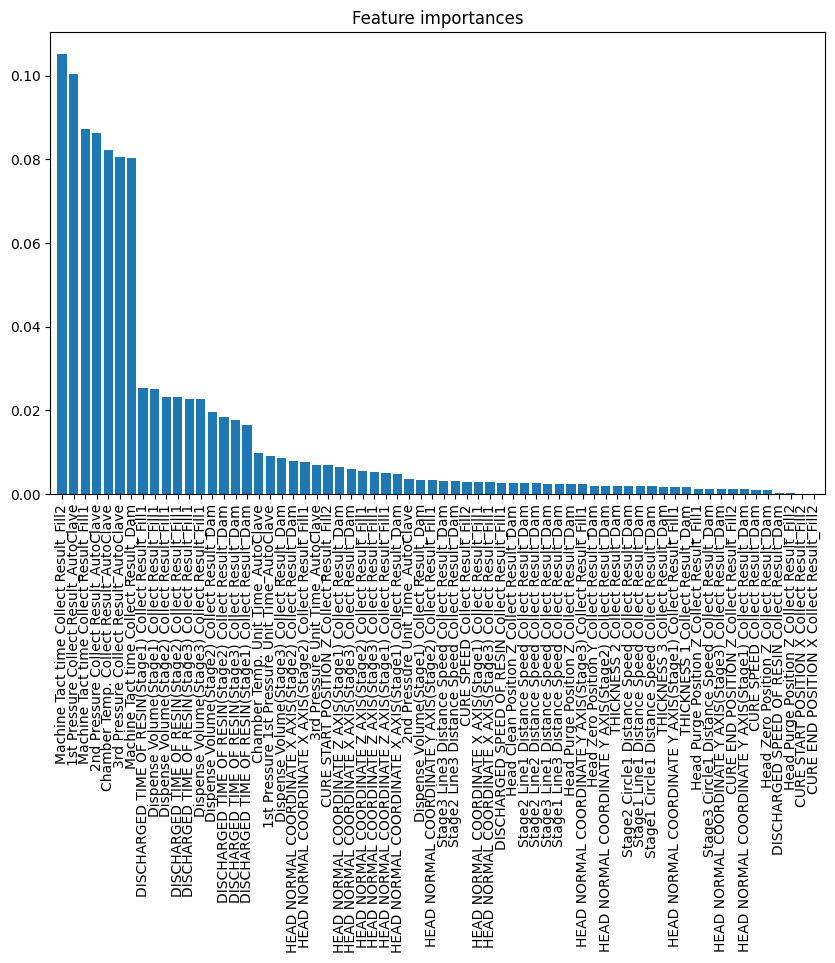

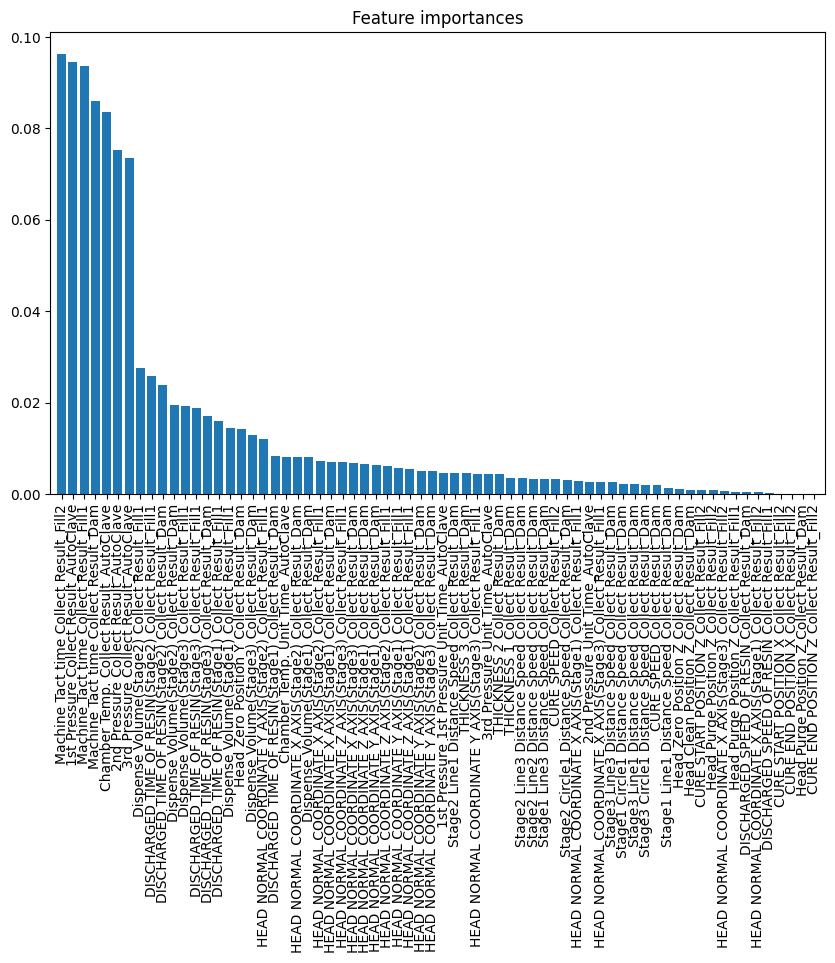

In [47]:

# 피쳐 중요성 얻기
importances = model1.feature_importances_

# 중요성을 시각화 (옵션)
import matplotlib.pyplot as plt

# 피쳐 이름 설정 (옵션)
feature_names = X_model1.columns

# 중요성 정렬
indices = np.argsort(importances)[::-1]

# 바 차트 그리기
plt.figure(figsize=(10,6))
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.title("Feature importances")
plt.bar(range(X_model1.shape[1]), importances[indices], align="center")
plt.xticks(range(X_model1.shape[1]), np.array(feature_names)[indices], rotation=90)
plt.xlim([-1, X_model1.shape[1]])
plt.show()


# 피쳐 중요성 얻기
importances = model2.feature_importances_

# 중요성을 시각화 (옵션)
import matplotlib.pyplot as plt

# 피쳐 이름 설정 (옵션)
feature_names = X_model2.columns

# 중요성 정렬
indices = np.argsort(importances)[::-1]

# 바 차트 그리기
plt.figure(figsize=(10,6))
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.title("Feature importances")
plt.bar(range(X_model2.shape[1]), importances[indices], align="center")
plt.xticks(range(X_model2.shape[1]), np.array(feature_names)[indices], rotation=90)
plt.xlim([-1, X_model2.shape[1]])
plt.show()

## 4. 제출하기


### 테스트 데이터 예측


테스트 데이터 불러오기


In [48]:
test_data = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))
test_data

,Set ID,Wip Line_Dam,Process Desc._Dam,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Insp. Seq No._Dam,Insp Judge Code_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION X Unit Time_Dam,...,Production Qty Collect Result_Fill2,Production Qty Unit Time_Fill2,Production Qty Judge Value_Fill2,Receip No Collect Result_Fill2,Receip No Unit Time_Fill2,Receip No Judge Value_Fill2,WorkMode Collect Result_Fill2,WorkMode Unit Time_Fill2,WorkMode Judge Value_Fill2,target
0,0001be084fbc4aaa9d921f39e595961b,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3J1XF767-1,1,OK,1000.0,NaN,...,195,NaN,NaN,1,NaN,NaN,0,NaN,NaN,NaN
1,0005bbd180064abd99e63f9ed3e1ac80,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4B1XD472-2,1,OK,1000.0,NaN,...,14,NaN,NaN,256,NaN,NaN,1,NaN,NaN,NaN
2,000948934c4140d883d670adcb609584,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3H1XE355-1,1,OK,240.0,NaN,...,98,NaN,NaN,1,NaN,NaN,0,NaN,NaN,NaN
3,000a6bfd02874c6296dc7b2e9c5678a7,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3L1XA128-1,1,OK,1000.0,NaN,...,14,NaN,NaN,0,NaN,NaN,1,NaN,NaN,NaN
4,0018e78ce91343678716e2ea27a51c95,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,4A1XA639-1,1,OK,240.0,NaN,...,1,NaN,NaN,215,NaN,NaN,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17356,ffea508b59934d689b540f95eb3fa730,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3K1XB597-1,1,OK,1000.0,NaN,...,14,NaN,NaN,131,NaN,NaN,1,NaN,NaN,NaN
17357,ffed8923c8a448a98afc641b770be153,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4A1XB974-1,1,OK,1000.0,NaN,...,12,NaN,NaN,279,NaN,NaN,1,NaN,NaN,NaN
17358,fff1e73734da40adbe805359b3efb462,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3L1XA998-1,1,OK,240.0,NaN,...,4,NaN,NaN,66,NaN,NaN,1,NaN,NaN,NaN
17359,fff8e38bdd09470baf95f71e92075dec,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3F1XC376-1,1,OK,240.0,NaN,...,117,NaN,NaN,1,NaN,NaN,0,NaN,NaN,NaN


In [49]:
# Drop columns with more than half of the values missing
drop_cols = []
for column in test_data.columns:
    if (test_data[column].notnull().sum() // 2) < test_data[
        column
    ].isnull().sum():
        drop_cols.append(column)
test_data = test_data.drop(drop_cols, axis=1)

test_data

,Set ID,Wip Line_Dam,Process Desc._Dam,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Insp. Seq No._Dam,Insp Judge Code_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,...,Head Clean Position Y Collect Result_Fill2,Head Clean Position Z Collect Result_Fill2,Head Purge Position X Collect Result_Fill2,Head Purge Position Y Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2
0,0001be084fbc4aaa9d921f39e595961b,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3J1XF767-1,1,OK,1000.0,12.5,...,50,91.8,270.0,50,85,19.8,13.0,195,1,0
1,0005bbd180064abd99e63f9ed3e1ac80,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4B1XD472-2,1,OK,1000.0,12.5,...,119,50.0,91.8,270,50,85.0,19.8,14,256,1
2,000948934c4140d883d670adcb609584,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3H1XE355-1,1,OK,240.0,2.5,...,50,91.8,270.0,50,85,19.7,1.0,98,1,0
3,000a6bfd02874c6296dc7b2e9c5678a7,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3L1XA128-1,1,OK,1000.0,12.5,...,119,50.0,91.8,270,50,85.0,20.0,14,0,1
4,0018e78ce91343678716e2ea27a51c95,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,4A1XA639-1,1,OK,240.0,2.5,...,119,50.0,91.8,270,50,85.0,19.8,1,215,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17356,ffea508b59934d689b540f95eb3fa730,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3K1XB597-1,1,OK,1000.0,12.5,...,119,50.0,91.8,270,50,85.0,19.5,14,131,1
17357,ffed8923c8a448a98afc641b770be153,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4A1XB974-1,1,OK,1000.0,12.5,...,119,50.0,91.8,270,50,85.0,19.8,12,279,1
17358,fff1e73734da40adbe805359b3efb462,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3L1XA998-1,1,OK,240.0,2.5,...,119,50.0,91.8,270,50,85.0,20.5,4,66,1
17359,fff8e38bdd09470baf95f71e92075dec,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3F1XC376-1,1,OK,240.0,2.5,...,50,91.8,270.0,50,85,18.9,1.0,117,1,0


In [50]:
# 각 열의 NaN 값 개수 계산
nan_counts = test_data.isnull().sum()

# NaN 값이 있는 열들만 필터링
nan_columns = nan_counts[nan_counts > 0]

nan_columns

HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam      5468
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1    5468
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2    5468
dtype: int64

In [51]:
# 각 열의 NaN 값이 있는 행을 표시
nan_dam = test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].isnull()
nan_fill1 = test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].isnull()
nan_fill2 = test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].isnull()

# 세 열의 NaN 값이 모두 같은 행에서 발생했는지 확인
nan_same_rows = nan_dam & nan_fill1 & nan_fill2

# NaN 값이 동일한 행의 개수 확인
num_same_nan_rows = nan_same_rows.sum()

# 결과 출력
print(f"세 열에서 NaN 값이 동일한 행의 개수: {num_same_nan_rows}")
print(f"세 열에서 NaN 값이 동일한 행:\n{test_data[nan_same_rows]}")

세 열에서 NaN 값이 동일한 행의 개수: 5468
세 열에서 NaN 값이 동일한 행:
                                 Set ID Wip Line_Dam Process Desc._Dam  \
3      000a6bfd02874c6296dc7b2e9c5678a7      IVI-OB6     Dam Dispenser   
8      00297b6c93e44d49ac534758a23dc74e      IVI-OB6     Dam Dispenser   
9      002d904240d84b188d410d16383a9c3a      IVI-OB6     Dam Dispenser   
10     002fdfad651c4a98b6f0c4046976aac3      IVI-OB6     Dam Dispenser   
13     0039b02541014d678d5b0e5a3cb3797a      IVI-OB6     Dam Dispenser   
...                                 ...          ...               ...   
17349  ffd71ad9aac547a4a367d538c6e3ee30      IVI-OB6     Dam Dispenser   
17354  ffe5c71ef7b045868d177023be7f364b      IVI-OB6     Dam Dispenser   
17355  ffe77be574b24429b1bf6a69b5c2c2ef      IVI-OB6     Dam Dispenser   
17356  ffea508b59934d689b540f95eb3fa730      IVI-OB6     Dam Dispenser   
17358  fff1e73734da40adbe805359b3efb462      IVI-OB6     Dam Dispenser   

          Equipment_Dam Model.Suffix_Dam Workorder_Dam  Insp. 

In [52]:
# 삭제할 열 리스트
columns_to_drop = [
        'Model.Suffix_Fill1', 'Model.Suffix_Fill2', 'Model.Suffix_AutoClave', 
        'Workorder_Fill1', 'Workorder_Fill2', 'Workorder_AutoClave'
]

# 열 삭제
test_data = test_data.drop(columns=columns_to_drop)

# 열 이름 변경
test_data = test_data.rename(columns={
    'Model.Suffix_Dam': 'Model.Suffix',
    'Workorder_Dam': 'Workorder'
})

test_data

,Set ID,Wip Line_Dam,Process Desc._Dam,Equipment_Dam,Model.Suffix,Workorder,Insp. Seq No._Dam,Insp Judge Code_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,...,Head Clean Position Y Collect Result_Fill2,Head Clean Position Z Collect Result_Fill2,Head Purge Position X Collect Result_Fill2,Head Purge Position Y Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2
0,0001be084fbc4aaa9d921f39e595961b,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3J1XF767-1,1,OK,1000.0,12.5,...,50,91.8,270.0,50,85,19.8,13.0,195,1,0
1,0005bbd180064abd99e63f9ed3e1ac80,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4B1XD472-2,1,OK,1000.0,12.5,...,119,50.0,91.8,270,50,85.0,19.8,14,256,1
2,000948934c4140d883d670adcb609584,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3H1XE355-1,1,OK,240.0,2.5,...,50,91.8,270.0,50,85,19.7,1.0,98,1,0
3,000a6bfd02874c6296dc7b2e9c5678a7,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3L1XA128-1,1,OK,1000.0,12.5,...,119,50.0,91.8,270,50,85.0,20.0,14,0,1
4,0018e78ce91343678716e2ea27a51c95,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,4A1XA639-1,1,OK,240.0,2.5,...,119,50.0,91.8,270,50,85.0,19.8,1,215,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17356,ffea508b59934d689b540f95eb3fa730,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3K1XB597-1,1,OK,1000.0,12.5,...,119,50.0,91.8,270,50,85.0,19.5,14,131,1
17357,ffed8923c8a448a98afc641b770be153,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4A1XB974-1,1,OK,1000.0,12.5,...,119,50.0,91.8,270,50,85.0,19.8,12,279,1
17358,fff1e73734da40adbe805359b3efb462,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3L1XA998-1,1,OK,240.0,2.5,...,119,50.0,91.8,270,50,85.0,20.5,4,66,1
17359,fff8e38bdd09470baf95f71e92075dec,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3F1XC376-1,1,OK,240.0,2.5,...,50,91.8,270.0,50,85,18.9,1.0,117,1,0


In [53]:
# 모든 행이 동일한 값을 가지는 열을 찾고, 그 값을 함께 저장
constant_columns = {col: test_data[col].iloc[0] for col in test_data.columns if test_data[col].nunique() == 1}

# 데이터 프레임에서 해당 열 삭제
test_data = test_data.drop(columns=constant_columns.keys())

# 삭제된 열의 개수 출력
print(f"삭제된 열의 개수: {len(constant_columns)}")

# 삭제된 열과 그 값을 한 줄에 하나씩 출력
print("삭제된 열과 값:")
for col, value in constant_columns.items():
    print(f"{col}: {value}")

test_data

삭제된 열의 개수: 35
삭제된 열과 값:
Wip Line_Dam: IVI-OB6
Process Desc._Dam: Dam Dispenser
Insp. Seq No._Dam: 1
Insp Judge Code_Dam: OK
CURE STANDBY POSITION X Collect Result_Dam: 1150
CURE STANDBY POSITION Z Collect Result_Dam: 33.5
CURE STANDBY POSITION Θ Collect Result_Dam: 0
CURE START POSITION Z Collect Result_Dam: 33.5
Wip Line_AutoClave: IVI-OB6
Process Desc._AutoClave: Auto Clave Out
Equipment_AutoClave: Auto Clave Out
Insp. Seq No._AutoClave: 1
Insp Judge Code_AutoClave: OK
1st Pressure Judge Value_AutoClave: OK
2nd Pressure Judge Value_AutoClave: OK
3rd Pressure Judge Value_AutoClave: OK
Wip Line_Fill1: IVI-OB6
Process Desc._Fill1: Fill1 Dispenser
Insp. Seq No._Fill1: 1
Insp Judge Code_Fill1: OK
Wip Line_Fill2: IVI-OB6
Process Desc._Fill2: Fill2 Dispenser
Insp. Seq No._Fill2: 1
Insp Judge Code_Fill2: OK
CURE END POSITION Θ Collect Result_Fill2: -90
CURE STANDBY POSITION X Collect Result_Fill2: 1020
CURE STANDBY POSITION Θ Collect Result_Fill2: 0
CURE START POSITION Θ Collect Result_Fill2

,Set ID,Equipment_Dam,Model.Suffix,Workorder,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,...,Head Clean Position Y Collect Result_Fill2,Head Clean Position Z Collect Result_Fill2,Head Purge Position X Collect Result_Fill2,Head Purge Position Y Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2
0,0001be084fbc4aaa9d921f39e595961b,Dam dispenser #2,AJX75334501,3J1XF767-1,1000.0,12.5,90,70,280,90,...,50,91.8,270.0,50,85,19.8,13.0,195,1,0
1,0005bbd180064abd99e63f9ed3e1ac80,Dam dispenser #2,AJX75334501,4B1XD472-2,1000.0,12.5,90,70,280,90,...,119,50.0,91.8,270,50,85.0,19.8,14,256,1
2,000948934c4140d883d670adcb609584,Dam dispenser #1,AJX75334501,3H1XE355-1,240.0,2.5,-90,70,1030,-90,...,50,91.8,270.0,50,85,19.7,1.0,98,1,0
3,000a6bfd02874c6296dc7b2e9c5678a7,Dam dispenser #2,AJX75334501,3L1XA128-1,1000.0,12.5,90,70,280,90,...,119,50.0,91.8,270,50,85.0,20.0,14,0,1
4,0018e78ce91343678716e2ea27a51c95,Dam dispenser #1,AJX75334501,4A1XA639-1,240.0,2.5,-90,70,1030,-90,...,119,50.0,91.8,270,50,85.0,19.8,1,215,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17356,ffea508b59934d689b540f95eb3fa730,Dam dispenser #2,AJX75334501,3K1XB597-1,1000.0,12.5,90,70,280,90,...,119,50.0,91.8,270,50,85.0,19.5,14,131,1
17357,ffed8923c8a448a98afc641b770be153,Dam dispenser #2,AJX75334501,4A1XB974-1,1000.0,12.5,90,70,280,90,...,119,50.0,91.8,270,50,85.0,19.8,12,279,1
17358,fff1e73734da40adbe805359b3efb462,Dam dispenser #1,AJX75334501,3L1XA998-1,240.0,2.5,-90,70,1030,-90,...,119,50.0,91.8,270,50,85.0,20.5,4,66,1
17359,fff8e38bdd09470baf95f71e92075dec,Dam dispenser #1,AJX75334501,3F1XC376-1,240.0,2.5,-90,70,1030,-90,...,50,91.8,270.0,50,85,18.9,1.0,117,1,0


In [54]:
# 열 이름 정의
column_name = 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'

# 데이터프레임에서 숫자와 숫자가 아닌 값으로 구분하여 두 개의 데이터프레임 생성
test_noshift = test_data[pd.to_numeric(test_data[column_name], errors='coerce').notna()]
test_shift = test_data[pd.to_numeric(test_data[column_name], errors='coerce').isna() | (test_data[column_name] == 'OK')]


In [55]:
# 선택할 열 범위
start_col = 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'
end_col = 'WorkMode Collect Result_Dam'

# 열 인덱스 찾기
start_index = test_shift.columns.get_loc(start_col)
end_index = test_shift.columns.get_loc(end_col)

# 선택할 열 범위 설정
cols_to_shift = test_shift.iloc[:, start_index:end_index + 1].copy()

# 선택한 열에 대해 shift 적용 (값만 이동)
shifted_values = cols_to_shift.shift(-1, axis=1)

# 원래 데이터프레임에서 선택한 열의 위치에 값만 덮어쓰기
for i, col in enumerate(cols_to_shift.columns):
    test_shift[col] = shifted_values.iloc[:, i]

/var/folders/zf/6h5l4dc57cj2qkp7wv1dz7zr0000gn/T/ipykernel_1412/578073771.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_shift[col] = shifted_values.iloc[:, i]


In [56]:
# 선택할 열 범위
start_col = 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'
end_col = 'WorkMode Collect Result_Fill1'

# 열 인덱스 찾기
start_index = test_shift.columns.get_loc(start_col)
end_index = test_shift.columns.get_loc(end_col)

# 선택할 열 범위 설정
cols_to_shift = test_shift.iloc[:, start_index:end_index + 1].copy()

# 선택한 열에 대해 shift 적용 (값만 이동)
shifted_values = cols_to_shift.shift(-1, axis=1)

# 원래 데이터프레임에서 선택한 열의 위치에 값만 덮어쓰기
for i, col in enumerate(cols_to_shift.columns):
    test_shift[col] = shifted_values.iloc[:, i]

/var/folders/zf/6h5l4dc57cj2qkp7wv1dz7zr0000gn/T/ipykernel_1412/577323871.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_shift[col] = shifted_values.iloc[:, i]


In [57]:
# 선택할 열 범위
start_col = 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'
end_col = 'WorkMode Collect Result_Fill2'

# 열 인덱스 찾기
start_index = test_shift.columns.get_loc(start_col)
end_index = test_shift.columns.get_loc(end_col)

# 선택할 열 범위 설정
cols_to_shift = test_shift.iloc[:, start_index:end_index + 1].copy()

# 선택한 열에 대해 shift 적용 (값만 이동)
shifted_values = cols_to_shift.shift(-1, axis=1)

# 원래 데이터프레임에서 선택한 열의 위치에 값만 덮어쓰기
for i, col in enumerate(cols_to_shift.columns):
    test_shift[col] = shifted_values.iloc[:, i]

/var/folders/zf/6h5l4dc57cj2qkp7wv1dz7zr0000gn/T/ipykernel_1412/3086852134.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_shift[col] = shifted_values.iloc[:, i]


In [58]:
# 두 데이터프레임 합치기
combined_df = pd.concat([test_shift, test_noshift], axis=0)
combined_df = combined_df.sort_index()

# 제거할 열 리스트
columns_to_drop = ['WorkMode Collect Result_Dam', 'WorkMode Collect Result_Fill1', 'WorkMode Collect Result_Fill2']

# 지정한 열 제거
combined_df = combined_df.drop(columns=columns_to_drop)

combined_df

,Set ID,Equipment_Dam,Model.Suffix,Workorder,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,...,Head Clean Position X Collect Result_Fill2,Head Clean Position Y Collect Result_Fill2,Head Clean Position Z Collect Result_Fill2,Head Purge Position X Collect Result_Fill2,Head Purge Position Y Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2
0,0001be084fbc4aaa9d921f39e595961b,Dam dispenser #2,AJX75334501,3J1XF767-1,1000.0,12.5,90,70,280,90,...,119,50.0,91.8,270.0,50,85.0,19.8,13.0,195,1
1,0005bbd180064abd99e63f9ed3e1ac80,Dam dispenser #2,AJX75334501,4B1XD472-2,1000.0,12.5,90,70,280,90,...,119,50.0,91.8,270.0,50,85.0,19.8,14.0,256,1
2,000948934c4140d883d670adcb609584,Dam dispenser #1,AJX75334501,3H1XE355-1,240.0,2.5,-90,70,1030,-90,...,119,50.0,91.8,270.0,50,85.0,19.7,1.0,98,1
3,000a6bfd02874c6296dc7b2e9c5678a7,Dam dispenser #2,AJX75334501,3L1XA128-1,1000.0,12.5,90,70,280,90,...,119,50.0,91.8,270.0,50,85.0,20.0,14.0,0,1
4,0018e78ce91343678716e2ea27a51c95,Dam dispenser #1,AJX75334501,4A1XA639-1,240.0,2.5,-90,70,1030,-90,...,119,50.0,91.8,270.0,50,85.0,19.8,1.0,215,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17356,ffea508b59934d689b540f95eb3fa730,Dam dispenser #2,AJX75334501,3K1XB597-1,1000.0,12.5,90,70,280,90,...,119,50.0,91.8,270.0,50,85.0,19.5,14.0,131,1
17357,ffed8923c8a448a98afc641b770be153,Dam dispenser #2,AJX75334501,4A1XB974-1,1000.0,12.5,90,70,280,90,...,119,50.0,91.8,270.0,50,85.0,19.8,12.0,279,1
17358,fff1e73734da40adbe805359b3efb462,Dam dispenser #1,AJX75334501,3L1XA998-1,240.0,2.5,-90,70,1030,-90,...,119,50.0,91.8,270.0,50,85.0,20.5,4.0,66,1
17359,fff8e38bdd09470baf95f71e92075dec,Dam dispenser #1,AJX75334501,3F1XC376-1,240.0,2.5,-90,70,1030,-90,...,119,50.0,91.8,270.0,50,85.0,18.9,1.0,117,1


In [59]:
# 모든 행이 동일한 값을 가지는 열을 찾고, 그 값을 함께 저장
constant_columns = {col: combined_df[col].iloc[0] for col in combined_df.columns if combined_df[col].nunique() == 1}

# 데이터 프레임에서 해당 열 삭제
combined_df = combined_df.drop(columns=constant_columns.keys())

# 삭제된 열의 개수 출력
print(f"삭제된 열의 개수: {len(constant_columns)}")

# 삭제된 열과 그 값을 한 줄에 하나씩 출력
print("삭제된 열과 값:")
for col, value in constant_columns.items():
    print(f"{col}: {value}")

combined_df

삭제된 열의 개수: 24
삭제된 열과 값:
HEAD Standby Position X Collect Result_Dam: 257.0
HEAD Standby Position Y Collect Result_Dam: 66
HEAD Standby Position Z Collect Result_Dam: 0.0
Head Clean Position X Collect Result_Dam: 127.5
Head Clean Position Y Collect Result_Dam: 66.0
Head Purge Position X Collect Result_Dam: 257.0
Head Purge Position Y Collect Result_Dam: 66.0
Head Zero Position X Collect Result_Dam: 505.0
HEAD Standby Position X Collect Result_Fill1: 289.0
HEAD Standby Position Y Collect Result_Fill1: 50
HEAD Standby Position Z Collect Result_Fill1: 0.0
Head Clean Position X Collect Result_Fill1: 123.4
Head Clean Position Y Collect Result_Fill1: 50.0
Head Clean Position Z Collect Result_Fill1: 92.2
Head Purge Position X Collect Result_Fill1: 289.0
Head Purge Position Y Collect Result_Fill1: 50
HEAD Standby Position X Collect Result_Fill2: 270.0
HEAD Standby Position Y Collect Result_Fill2: 50
HEAD Standby Position Z Collect Result_Fill2: -10
Head Clean Position X Collect Result_Fill2: 119

,Set ID,Equipment_Dam,Model.Suffix,Workorder,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,...,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2
0,0001be084fbc4aaa9d921f39e595961b,Dam dispenser #2,AJX75334501,3J1XF767-1,1000.0,12.5,90,70,280,90,...,1324.2,1324.2,243.5,243.5,243.5,85.0,19.8,13.0,195,1
1,0005bbd180064abd99e63f9ed3e1ac80,Dam dispenser #2,AJX75334501,4B1XD472-2,1000.0,12.5,90,70,280,90,...,1324.2,1324.2,243.5,243.5,243.5,85.0,19.8,14.0,256,1
2,000948934c4140d883d670adcb609584,Dam dispenser #1,AJX75334501,3H1XE355-1,240.0,2.5,-90,70,1030,-90,...,427.9,428.0,243.7,243.7,243.7,85.0,19.7,1.0,98,1
3,000a6bfd02874c6296dc7b2e9c5678a7,Dam dispenser #2,AJX75334501,3L1XA128-1,1000.0,12.5,90,70,280,90,...,1324.2,1324.2,243.5,243.5,243.5,85.0,20.0,14.0,0,1
4,0018e78ce91343678716e2ea27a51c95,Dam dispenser #1,AJX75334501,4A1XA639-1,240.0,2.5,-90,70,1030,-90,...,427.9,428.0,243.7,243.7,243.7,85.0,19.8,1.0,215,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17356,ffea508b59934d689b540f95eb3fa730,Dam dispenser #2,AJX75334501,3K1XB597-1,1000.0,12.5,90,70,280,90,...,1324.2,1324.2,243.5,243.5,243.5,85.0,19.5,14.0,131,1
17357,ffed8923c8a448a98afc641b770be153,Dam dispenser #2,AJX75334501,4A1XB974-1,1000.0,12.5,90,70,280,90,...,1324.2,1324.2,243.5,243.5,243.5,85.0,19.8,12.0,279,1
17358,fff1e73734da40adbe805359b3efb462,Dam dispenser #1,AJX75334501,3L1XA998-1,240.0,2.5,-90,70,1030,-90,...,427.9,428.0,243.7,243.7,243.7,85.0,20.5,4.0,66,1
17359,fff8e38bdd09470baf95f71e92075dec,Dam dispenser #1,AJX75334501,3F1XC376-1,240.0,2.5,-90,70,1030,-90,...,427.9,428.0,243.7,243.7,243.7,85.0,18.9,1.0,117,1


In [60]:
# 변환할 열들의 리스트
columns_to_convert = [
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2']

# 각 열을 float로 변환
for col in columns_to_convert:
    combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')

combined_df[columns_to_convert].dtypes

HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam      float64
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1    float64
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2    float64
dtype: object

In [61]:
from itertools import combinations
from collections import defaultdict

# 동일한 값을 가지는 열 쌍을 저장할 리스트
equal_columns = []

# 열 이름들의 모든 쌍을 생성하여 비교
for col1, col2 in combinations(combined_df.columns, 2):
    if combined_df[col1].equals(combined_df[col2]):
        equal_columns.append((col1, col2))

# 열 쌍을 그룹화하여 저장할 딕셔너리
grouped_columns = defaultdict(set)

# 열 쌍을 그룹화
for col1, col2 in equal_columns:
    grouped_columns[col1].add(col2)
    grouped_columns[col2].add(col1)

# 방문한 열을 추적할 집합
visited = set()

# 그룹화된 열 쌍 출력
print("같은 값을 가지는 열 그룹:")
for col, group in grouped_columns.items():
    if col not in visited:
        # 현재 열과 연결된 모든 열을 그룹으로 묶기
        group.add(col)
        visited.update(group)
        print(f"그룹: {', '.join(group)}")

같은 값을 가지는 열 그룹:
그룹: CURE START POSITION Θ Collect Result_Dam, CURE END POSITION Θ Collect Result_Dam
그룹: HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam, HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam, HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam
그룹: Receip No Collect Result_Dam, Receip No Collect Result_Fill1, Receip No Collect Result_Fill2
그룹: Stage1 Line2 Distance Speed Collect Result_Dam, Stage1 Circle1 Distance Speed Collect Result_Dam, Stage1 Circle4 Distance Speed Collect Result_Dam, Stage1 Circle3 Distance Speed Collect Result_Dam, Stage1 Line4 Distance Speed Collect Result_Dam, Stage1 Circle2 Distance Speed Collect Result_Dam
그룹: Stage2 Circle3 Distance Speed Collect Result_Dam, Stage2 Circle1 Distance Speed Collect Result_Dam, Stage2 Circle2 Distance Speed Collect Result_Dam, Stage2 Circle4 Distance Speed Collect Result_Dam
그룹: Stage2 Line2 Distance Speed Collect Result_Dam, Stage2 Line4 Distance Speed Collect Result_Dam
그룹: Stage3 Circle2 Dista

In [62]:
# 삭제할 열 목록
columns_to_drop = [
    'CURE END POSITION Θ Collect Result_Dam',

    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam',

    'Stage1 Circle2 Distance Speed Collect Result_Dam',
    'Stage1 Circle3 Distance Speed Collect Result_Dam',
    'Stage1 Circle4 Distance Speed Collect Result_Dam',
    'Stage1 Line2 Distance Speed Collect Result_Dam',
    'Stage1 Line4 Distance Speed Collect Result_Dam',

    'Stage2 Circle2 Distance Speed Collect Result_Dam',
    'Stage2 Circle3 Distance Speed Collect Result_Dam',
    'Stage2 Circle4 Distance Speed Collect Result_Dam',

    'Stage2 Line4 Distance Speed Collect Result_Dam',

    'Stage3 Circle2 Distance Speed Collect Result_Dam',
    'Stage3 Circle3 Distance Speed Collect Result_Dam',
    'Stage3 Circle4 Distance Speed Collect Result_Dam',
    'Stage3 Line2 Distance Speed Collect Result_Dam',
    'Stage3 Line4 Distance Speed Collect Result_Dam',

    'CURE STANDBY POSITION Z Collect Result_Fill2',

    'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2',

    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2',

    'Model.Suffix', 
    'Chamber Temp. Judge Value_AutoClave',
    'Workorder'
]

# 열 삭제
combined_df = combined_df.drop(columns=columns_to_drop)

# 결과 확인
combined_df

,Set ID,Equipment_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,...,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2
0,0001be084fbc4aaa9d921f39e595961b,Dam dispenser #2,1000.0,12.5,70,280,90,10,17.0,4.9,...,499.8,694.0,1324.2,1324.2,243.5,85.0,19.8,13.0,195,1
1,0005bbd180064abd99e63f9ed3e1ac80,Dam dispenser #2,1000.0,12.5,70,280,90,16,14.2,8.3,...,499.8,694.0,1324.2,1324.2,243.5,85.0,19.8,14.0,256,1
2,000948934c4140d883d670adcb609584,Dam dispenser #1,240.0,2.5,70,1030,-90,10,9.7,4.9,...,458.0,156.0,428.0,427.9,243.7,85.0,19.7,1.0,98,1
3,000a6bfd02874c6296dc7b2e9c5678a7,Dam dispenser #2,1000.0,12.5,70,280,90,10,21.3,10.6,...,499.8,694.0,1324.2,1324.2,243.5,85.0,20.0,14.0,0,1
4,0018e78ce91343678716e2ea27a51c95,Dam dispenser #1,240.0,2.5,70,1030,-90,16,13.2,7.5,...,458.0,156.0,428.0,427.9,243.7,85.0,19.8,1.0,215,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17356,ffea508b59934d689b540f95eb3fa730,Dam dispenser #2,1000.0,12.5,70,280,90,10,21.3,10.6,...,499.8,694.0,1324.2,1324.2,243.5,85.0,19.5,14.0,131,1
17357,ffed8923c8a448a98afc641b770be153,Dam dispenser #2,1000.0,12.5,70,280,90,16,13.2,7.6,...,499.8,694.0,1324.2,1324.2,243.5,85.0,19.8,12.0,279,1
17358,fff1e73734da40adbe805359b3efb462,Dam dispenser #1,240.0,2.5,70,1030,-90,16,13.2,6.6,...,458.0,156.0,428.0,427.9,243.7,85.0,20.5,4.0,66,1
17359,fff8e38bdd09470baf95f71e92075dec,Dam dispenser #1,240.0,2.5,70,1030,-90,10,9.7,3.9,...,458.0,156.0,428.0,427.9,243.7,85.0,18.9,1.0,117,1


In [63]:
test_data = combined_df
test_data[categorical_features] = encoder.transform(test_data[categorical_features])

In [64]:
condition_receip = (
    (test_data['Receip No Collect Result_Dam'] != test_data['Receip No Collect Result_Fill1']) |
    (test_data['Receip No Collect Result_Dam'] != test_data['Receip No Collect Result_Fill2']) |
    (test_data['Receip No Collect Result_Fill1'] != test_data['Receip No Collect Result_Fill2'])
)

condition_production_qty = (
    (test_data['Production Qty Collect Result_Dam'] != test_data['Production Qty Collect Result_Fill1']) |
    (test_data['Production Qty Collect Result_Dam'] != test_data['Production Qty Collect Result_Fill2']) |
    (test_data['Production Qty Collect Result_Fill1'] != test_data['Production Qty Collect Result_Fill2'])
)

condition_palletid = (
    (test_data['PalletID Collect Result_Dam'] != test_data['PalletID Collect Result_Fill1']) |
    (test_data['PalletID Collect Result_Dam'] != test_data['PalletID Collect Result_Fill2']) |
    (test_data['PalletID Collect Result_Fill1'] != test_data['PalletID Collect Result_Fill2'])
)

# abnormal로 제외할 조건들
test_equip1 = test_data[categorical_features].eq(0).all(axis=1)
test_equip2 = test_data[categorical_features].eq(1).all(axis=1)
condition_equip_different = ~test_equip1 & ~test_equip2

# 네 조건 중 하나라도 만족하면 불량으로 분류
condition_abnormal = condition_receip | condition_production_qty | condition_palletid | condition_equip_different

# 불량 데이터와 정상 데이터로 분리
test_match_abnormal = test_data[condition_abnormal]  # 불량 데이터
test_filtered = test_data[~condition_abnormal]  # 정상 데이터

# 정상 데이터에서 장비별로 데이터 분리
test_model1 = test_filtered[test_filtered[categorical_features].eq(0).all(axis=1)]
test_model2 = test_filtered[test_filtered[categorical_features].eq(1).all(axis=1)]
test_setid1 = test_model1['Set ID']
test_setid2 = test_model2['Set ID']
test_model1_for_prediction = test_model1.drop(columns=['Set ID'])
test_model2_for_prediction = test_model2.drop(columns=['Set ID'])

In [65]:
test_model1_for_prediction

,Equipment_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,...,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2
2,0.0,240.0,2.5,70,1030,-90,10,9.7,4.9,9.7,...,458.0,156.0,428.0,427.9,243.7,85.0,19.7,1.0,98,1
4,0.0,240.0,2.5,70,1030,-90,16,13.2,7.5,13.2,...,458.0,156.0,428.0,427.9,243.7,85.0,19.8,1.0,215,1
5,0.0,240.0,2.5,70,1030,-90,10,9.6,4.9,9.7,...,458.0,156.0,428.0,427.9,243.7,85.0,19.0,4.0,12,1
6,0.0,240.0,2.5,70,1030,-90,10,9.6,4.9,9.7,...,458.0,156.0,428.0,427.9,243.7,85.0,19.2,4.0,62,1
7,0.0,240.0,2.5,70,1030,-90,10,9.7,4.9,9.7,...,458.0,156.0,428.0,427.9,243.7,85.0,19.1,4.0,41,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17353,0.0,240.0,2.5,70,1030,-90,10,9.6,3.9,9.7,...,458.0,156.0,428.0,427.9,243.7,85.0,18.7,7.0,231,1
17355,0.0,240.0,2.5,70,1030,-90,10,21.3,5.5,21.3,...,458.0,156.0,428.0,427.9,243.7,85.0,19.7,8.0,117,1
17358,0.0,240.0,2.5,70,1030,-90,16,13.2,6.6,13.2,...,458.0,156.0,428.0,427.9,243.7,85.0,20.5,4.0,66,1
17359,0.0,240.0,2.5,70,1030,-90,10,9.7,3.9,9.7,...,458.0,156.0,428.0,427.9,243.7,85.0,18.9,1.0,117,1


In [66]:
# 매치 구분하느라 사용한 학습에 필요없는 컬럼 제외 
remove_columns=["PalletID Collect Result_Dam","PalletID Collect Result_Fill1","PalletID Collect Result_Fill2",
                "Production Qty Collect Result_Dam","Production Qty Collect Result_Fill1","Production Qty Collect Result_Fill2", 
                "Receip No Collect Result_Dam","Receip No Collect Result_Fill1","Receip No Collect Result_Fill2"]
# 데이터프레임에서 컬럼 제거
test_model1_for_prediction.drop(columns=remove_columns, inplace=True)
test_model2_for_prediction.drop(columns=remove_columns, inplace=True)

# drop feature (model1,2에서 중복되던 컬럼 제거)
test_model1_for_prediction.drop(columns=drop_column1,inplace=True)
test_model2_for_prediction.drop(columns=drop_column2,inplace=True)

In [67]:
test_model2_for_prediction

,CURE SPEED Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam,...,Machine Tact time Collect Result_Fill1,CURE END POSITION X Collect Result_Fill2,CURE END POSITION Z Collect Result_Fill2,CURE SPEED Collect Result_Fill2,CURE START POSITION X Collect Result_Fill2,CURE START POSITION Z Collect Result_Fill2,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2
0,70,10,17.0,4.9,17.0,1.19,0.34,1.19,162.4,465.3,...,57.9,240,33,50,1020,33,305.0,694.0,85.000,19.8
1,70,16,14.2,8.3,14.2,0.99,0.58,0.99,162.4,465.4,...,57.4,240,33,50,1020,33,305.0,694.0,85.000,19.8
3,70,10,21.3,10.6,21.3,1.49,0.74,1.49,164.2,467.1,...,68.3,240,33,50,1020,33,305.0,694.0,85.000,20.0
9,70,16,13.2,6.5,13.1,1.45,0.71,1.44,164.2,467.1,...,56.2,240,33,50,1020,33,305.0,694.0,85.000,19.7
10,70,10,21.3,10.5,21.3,1.49,0.73,1.49,164.2,467.1,...,67.9,240,33,50,1020,33,305.0,694.0,85.000,19.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17351,95,16,14.7,8.6,14.7,1.02,0.60,1.02,162.4,465.4,...,58.7,240,33,50,1020,33,305.0,694.0,85.000,20.2
17352,85,16,14.7,8.6,14.7,1.61,0.94,1.61,162.4,465.4,...,58.7,240,33,50,1020,33,305.0,694.0,114.612,19.6
17354,70,16,13.2,6.6,13.2,1.45,0.72,1.45,164.2,467.1,...,51.7,240,33,50,1020,33,305.0,694.0,85.000,20.2
17356,70,10,21.3,10.6,21.3,1.49,0.74,1.49,162.4,465.5,...,72.9,240,33,50,1020,33,305.0,694.0,85.000,19.5


In [68]:
# Scaling test data

test_model1_scaled = scaler1.transform(test_model1_for_prediction)
test_model2_scaled = scaler2.transform(test_model2_for_prediction)


In [73]:
test_model1_pred = model1.predict(test_model1_scaled)
test_model2_pred = model2.predict(test_model2_scaled)

# 검증 데이터의 전체 예측을 위한 결과 결합
final_predictions = []

test_model1_index = test_setid2.index
test_model2_index = test_setid2.index

for idx in test_data.index:
    if idx in test_model1_index:
        final_predictions.append(test_model1_pred[test_model1_index.get_loc(idx)])
    elif idx in test_model2_index:
        final_predictions.append(test_model2_pred[test_model2_index.get_loc(idx)])
    else:
        final_predictions.append('AbNormal')


/Users/kkw/myvenv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/kkw/myvenv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### 제출 파일 작성


In [76]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("./submission.csv")
df_sub["target"] = final_predictions

# 제출 파일 저장
df_sub.to_csv("./submission.csv", index=False)

In [77]:
df_sub

,Set ID,target
0,0001be084fbc4aaa9d921f39e595961b,Normal
1,0005bbd180064abd99e63f9ed3e1ac80,Normal
2,000948934c4140d883d670adcb609584,AbNormal
3,000a6bfd02874c6296dc7b2e9c5678a7,Normal
4,0018e78ce91343678716e2ea27a51c95,AbNormal
...,...,...
17356,ffea508b59934d689b540f95eb3fa730,Normal
17357,ffed8923c8a448a98afc641b770be153,Normal
17358,fff1e73734da40adbe805359b3efb462,AbNormal
17359,fff8e38bdd09470baf95f71e92075dec,AbNormal


In [78]:
# 고유 값과 빈도 계산
unique_values, counts = np.unique(final_predictions, return_counts=True)
print("pred target")
# 결과 출력
for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")
print('\n')


pred target
AbNormal: 11042
Normal: 6319




**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**
